# Examen 2

Lucho Feb|2025 

Que Vendra by Zaz

## Consigna

### Problema de Predicción de Ventas

### Descripción del Problema
Se proporciona un dataset con datos transaccionales referidos a ventas de distintos productos. El objetivo es construir un modelo de regresión simple para predecir las ventas por producto de una tienda en particular, que forma parte de una cadena de tiendas, y descubrir cuáles son los principales factores que influencian dicha predicción.

### Asunciones
- **Categoría del producto**: Podría tener cierto impacto en las ventas. Se asume que los productos de consumo general se venden más que las bebidas alcohólicas.
- **Tipo de tienda y ubicación**: Es importante para las ventas. Las tiendas en diferentes ubicaciones pueden tener comportamientos de ventas diferentes.
- **Tamaño de la tienda**: Puede ser relevante. La pregunta es si los clientes prefieren tiendas grandes para comprar todo lo que necesitan de una vez y obtener mejores precios, o si prefieren visitar tiendas más pequeñas.

### Tareas a Realizar
1. **Descargar y analizar los datos**:
   - Limpieza de datos
   - Gráficos
   - Tablas

2. **Procesamiento de datos**:
   - Selección de variables importantes para el modelo
   - Feature engineering para variables numéricas, categóricas y datetimes

3. **Modelado**:
   - Entrenamiento del modelo
   - Cálculo de métricas apropiadas
   - Análisis de las principales variables que utiliza el modelo

4. **Test**:
   - Aplicación del modelo en el dataset de test.

La solución deberá ser legible, reproducible y eficiente para la resolución del challenge. Se puede utilizar cualquier tipo de gráfico o tabla para mostrar la información de la manera que se considere adecuada.

### Archivos Proporcionados
Los archivos `train` y `test` tienen la misma estructura. Las columnas que contienen son las siguientes:

- **Item_Identifier** (Object): Nombre o identificador del producto
- **Item_Weight** (Float): Peso del producto en gramos
- **Item_Fat_Content** (Object): Clasificación del producto en términos de grasas contenidas en él
- **Item_Visibility** (Float): Scoring de visibilidad del producto. Mide qué tan fácil puede ser encontrado el producto por los consumidores
- **Item_Type** (Object): Tipo de producto
- **Item_MRP** (Float): Maximum Retail Price. Precio calculado por el fabricante que indica el precio más alto que se puede cobrar por el producto
- **Outlet_Identifier** (Object): Identificador de la tienda
- **Outlet_Establishment_Year**(Float): Año de lanzamiento de la tienda
- **Outlet_Size** (Object): Tamaño de la tienda
- **Outlet_Location_Type** (Object): Clasificación de las tiendas según ubicación
- **Outlet_Type** (Object): Tipo de tienda
- **Item_Outlet_Sales** (Float): Ventas del producto en cada observación


### Presentacion resultado

- El entregable principal es un Informe con tus respuestas: puede ser un Jupyter Notebook, una presentación en PPT o similar, un HTML, o como lo prefieras. Queremos conocer detalles como los criterios utilizados, dificultades encontradas en el camino y resultados parciales.
  - ¿Qué otras fuentes de datos o información crees que serían interesantes para mejorar tu análisis?

- Podés usar cualquier lenguaje, herramientas y servicios en la nube que desees.
  - Nos gustaría ver tu código o implementación.

- Tendrás una presentación de 30 minutos para mostrar los resultados.

- Esperamos recibir tu trabajo en alrededor de 1 semana posterior al envío del challenge.

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl

from xgboost import XGBRegressor
import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.impute import SimpleImputer
import lightgbm as lgb
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.exceptions import NotFittedError
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from scipy.stats import chi2_contingency, pearsonr, spearmanr, f_oneway, kurtosis
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_absolute_error
from sklearn.ensemble import VotingRegressor


from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve, cross_val_predict,train_test_split,LearningCurveDisplay
from sklearn.model_selection import KFold

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


import warnings
from joblib import dump, load


### Import Datasets

#### Train

In [2]:
train = pd.read_csv("Train_BigMart.csv")
train_raw = train.copy()

test = pd.read_csv("Test_BigMart.csv")
test_raw = test.copy()

for df in [train,test]:
    df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'low fat': 'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular'})

train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
train.shape

(8523, 12)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [5]:
train.duplicated().sum()

0

In [6]:
## Valores faltantes de Train
percent_missing = train.isnull().sum() * 100 / len(train)
missing_value_df = pd.DataFrame({'column_name': train.columns,
                                 'percent_missing': percent_missing})
missing_value_df

,column_name,percent_missing
Item_Identifier,Item_Identifier,0.000000
Item_Weight,Item_Weight,17.165317
Item_Fat_Content,Item_Fat_Content,0.000000
Item_Visibility,Item_Visibility,0.000000
Item_Type,Item_Type,0.000000
Item_MRP,Item_MRP,0.000000
Outlet_Identifier,Outlet_Identifier,0.000000
Outlet_Establishment_Year,Outlet_Establishment_Year,0.000000
Outlet_Size,Outlet_Size,28.276428
Outlet_Location_Type,Outlet_Location_Type,0.000000


In [7]:
#Train
def explore_data(df):
    print("\nInformación del dataset:")
    print(df.info())
    print("\nValores nulos:")
    print(df.isnull().sum())
    print("\nDescripción estadística:")
    print(df.describe())

explore_data(train)


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB
None

Valores nulos

In [8]:
train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


#### Test

In [9]:
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,Regular,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [10]:
test.shape

(5681, 11)

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                4705 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


In [12]:
## Valores faltantes de Train
percent_missing = test.isnull().sum() * 100 / len(test)
missing_value_df = pd.DataFrame({'column_name': test.columns,
                                 'percent_missing': percent_missing})
missing_value_df

,column_name,percent_missing
Item_Identifier,Item_Identifier,0.000000
Item_Weight,Item_Weight,17.180074
Item_Fat_Content,Item_Fat_Content,0.000000
Item_Visibility,Item_Visibility,0.000000
Item_Type,Item_Type,0.000000
Item_MRP,Item_MRP,0.000000
Outlet_Identifier,Outlet_Identifier,0.000000
Outlet_Establishment_Year,Outlet_Establishment_Year,0.000000
Outlet_Size,Outlet_Size,28.269671
Outlet_Location_Type,Outlet_Location_Type,0.000000


In [13]:
test.duplicated().sum()

0

In [14]:
#Test
explore_data(test)


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                4705 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB
None

Valores nulos:
Item_Identifier                 0
Item_Weight         

In [15]:
test.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,4705.000000,5681.000000,5681.000000,5681.000000
mean,12.695633,0.065684,141.023273,1997.828903
std,4.664849,0.051252,61.809091,8.372256
min,4.555000,0.000000,31.990000,1985.000000
25%,8.645000,0.027047,94.412000,1987.000000
50%,12.500000,0.054154,141.415400,1999.000000
75%,16.700000,0.093463,186.026600,2004.000000
max,21.350000,0.323637,266.588400,2009.000000


Nota: Al hacer un breve analisis, se ve que los 2 datasets son distintas columnas, y ademas en ambos casos el 45% de los datos faltan. Ahora se hara un analisis, para determinar el tratamiento de los datos.

### Analisis de Variables, Visualizacion & EDA

In [16]:
# Analisis de Train
# Variables categóricas
categorical_columns = train.select_dtypes(include=['object', 'category']).columns

# Variables continuas
continuous_columns = train.select_dtypes(include=['float64']).columns

# Variables discretas
discrete_columns = train.select_dtypes(include=['int64']).columns

# Mostrar las variables
print("Variables categóricas:")
print(categorical_columns)

print("\nVariables continuas:")
print(continuous_columns)

print("\nVariables discretas:")
print(discrete_columns)

Variables categóricas:
Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

Variables continuas:
Index(['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales'], dtype='object')

Variables discretas:
Index(['Outlet_Establishment_Year'], dtype='object')


In [17]:
# Analisis de Test
# Variables categóricas
categorical_columns = test.select_dtypes(include=['object', 'category']).columns

# Variables continuas
continuous_columns = test.select_dtypes(include=['float64']).columns

# Variables discretas
discrete_columns = test.select_dtypes(include=['int64']).columns

# Mostrar las variables
print("Variables categóricas:")
print(categorical_columns)

print("\nVariables continuas:")
print(continuous_columns)

print("\nVariables discretas:")
print(discrete_columns)

Variables categóricas:
Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

Variables continuas:
Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')

Variables discretas:
Index(['Outlet_Establishment_Year'], dtype='object')


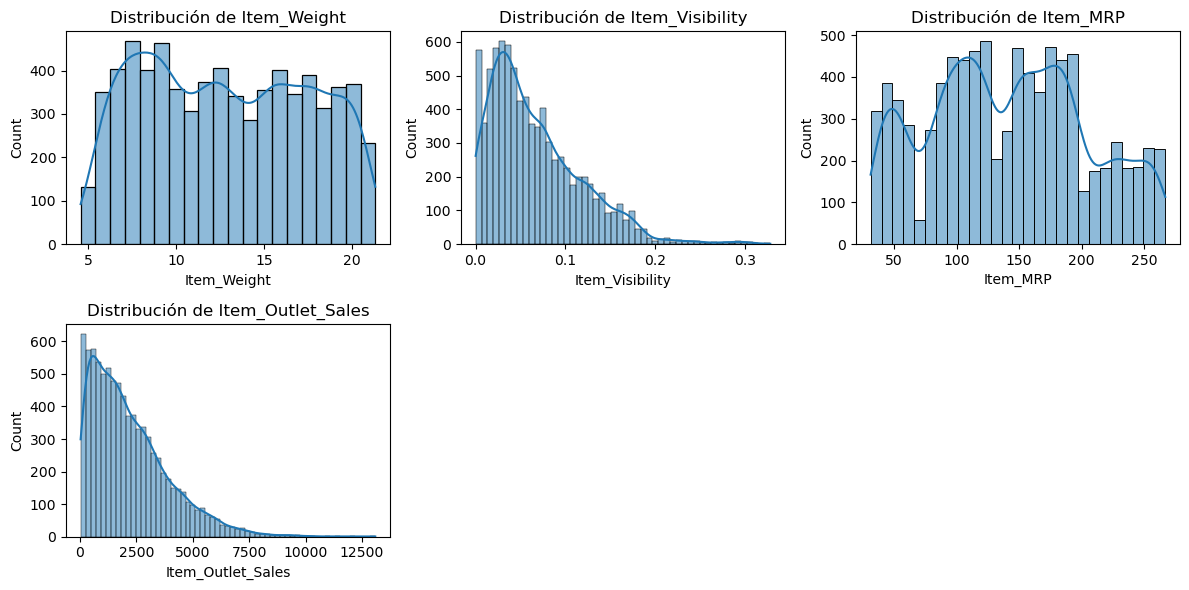

In [18]:
# Visualización inicial
def plot_distributions(df, columns):
    plt.figure(figsize=(12, 6))
    for i, col in enumerate(columns):
        plt.subplot(2, 3, i+1)
        sns.histplot(df[col], kde=True)
        plt.title(f"Distribución de {col}")
    plt.tight_layout()
    plt.show()

plot_distributions(train, ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales'])

In [19]:
# Veo las ventas de los outlets, segun el train
sales_by_outlet = train.groupby('Outlet_Type')['Item_Outlet_Sales'].agg(['count', 'mean', 'sum']).reset_index()
sales_by_outlet.columns = ['Outlet_Type', 'Productos Vendidos', 'Ventas Promedio', 'Ventas Totales']
print("Veo las ventas de los outlets")
print(sales_by_outlet)

Veo las ventas de los outlets
         Outlet_Type  Productos Vendidos  Ventas Promedio  Ventas Totales
0      Grocery Store                1083       339.828500    3.680343e+05
1  Supermarket Type1                5577      2316.181148    1.291734e+07
2  Supermarket Type2                 928      1995.498739    1.851823e+06
3  Supermarket Type3                 935      3694.038558    3.453926e+06


In [20]:
#Cantidad de ventas segun la categoria
sales_by_item_type = train.groupby('Item_Type')['Item_Outlet_Sales'].agg(['count', 'mean', 'sum']).reset_index()
sales_by_item_type.columns = ['Tipo de Producto', 'Cantidad de Productos', 'Ventas Promedio', 'Ventas Totales']
print("Cantidad de ventas segun la categoria")
sales_by_item_type

Cantidad de ventas segun la categoria


,Tipo de Producto,Cantidad de Productos,Ventas Promedio,Ventas Totales
0,Baking Goods,648,1952.971207,1.265525e+06
1,Breads,251,2204.132226,5.532372e+05
2,Breakfast,110,2111.808651,2.322990e+05
3,Canned,649,2225.194904,1.444151e+06
4,Dairy,682,2232.542597,1.522594e+06
5,Frozen Foods,856,2132.867744,1.825735e+06
6,Fruits and Vegetables,1232,2289.009592,2.820060e+06
7,Hard Drinks,214,2139.221622,4.577934e+05
8,Health and Hygiene,520,2010.000265,1.045200e+06
9,Household,910,2258.784300,2.055494e+06


In [21]:
#Ventas segun el contenido de grasa
fat_content_sales = train.groupby('Item_Fat_Content')['Item_Outlet_Sales'].agg(['count', 'mean', 'sum']).reset_index()
fat_content_sales.columns = ['Contenido de Grasa', 'Cantidad de Productos', 'Ventas Promedio', 'Ventas Totales']
print("Ventas segun el contenido de grasa")
print(fat_content_sales)

Ventas segun el contenido de grasa
  Contenido de Grasa  Cantidad de Productos  Ventas Promedio  Ventas Totales
0            Low Fat                   5517      2157.711534    1.190409e+07
1            Regular                   3006      2224.561170    6.687031e+06


In [22]:
#Cantidad de tiendas segun el tamaño
outlet_counts = train.groupby(['Outlet_Type', 'Outlet_Size']).size().reset_index(name='Cantidad de Tiendas')
print("Cantidad de tiendas segun el tamaño")
print(outlet_counts)

Cantidad de tiendas segun el tamaño
         Outlet_Type Outlet_Size  Cantidad de Tiendas
0      Grocery Store       Small                  528
1  Supermarket Type1        High                  932
2  Supermarket Type1      Medium                  930
3  Supermarket Type1       Small                 1860
4  Supermarket Type2      Medium                  928
5  Supermarket Type3      Medium                  935


In [23]:
#Productos con mas ventas
top_products = train.groupby('Item_Identifier')['Item_Outlet_Sales'].sum().reset_index()
top_products = top_products.sort_values(by='Item_Outlet_Sales', ascending=False).head(10)
print("Productos con mas ventas")
print(top_products)

Productos con mas ventas
     Item_Identifier  Item_Outlet_Sales
1210           FDY55         42661.8008
156            FDA15         41584.5364
1230           FDZ20         40185.0248
359            FDF05         36555.7490
148            FDA04         35741.4756
544            FDK03         34843.9772
1454           NCQ06         34680.1904
1464           NCQ53         34508.4140
538            FDJ55         33531.0196
305            FDD44         32723.4042


In [24]:
#Ventas por año
sales_by_year = train.groupby('Outlet_Establishment_Year')['Item_Outlet_Sales'].agg(['count', 'mean', 'sum']).reset_index()
sales_by_year.columns = ['Año de Establecimiento', 'Cantidad de Productos', 'Ventas Promedio', 'Ventas Totales']
print("Ventas por año")
sales_by_year

Ventas por año


,Año de Establecimiento,Cantidad de Productos,Ventas Promedio,Ventas Totales
0,1985,1463,2483.677474,3.633620e+06
1,1987,932,2298.995256,2.142664e+06
2,1997,930,2277.844267,2.118395e+06
3,1998,555,339.351662,1.883402e+05
4,1999,930,2348.354635,2.183970e+06
5,2002,929,2192.384798,2.036725e+06
6,2004,930,2438.841866,2.268123e+06
7,2007,926,2340.675263,2.167465e+06
8,2009,928,1995.498739,1.851823e+06


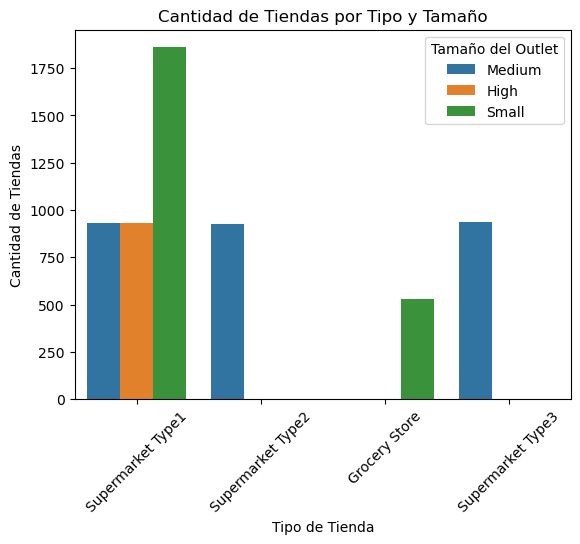

In [25]:
sns.countplot(x=train['Outlet_Type'], hue=train['Outlet_Size'])
plt.title("Cantidad de Tiendas por Tipo y Tamaño")
plt.xlabel("Tipo de Tienda")
plt.ylabel("Cantidad de Tiendas")
plt.xticks(rotation=45)
plt.legend(title="Tamaño del Outlet")
plt.show()

**NOTA:** Tras realizar un análisis preliminar de las columnas principales, se observó que los conjuntos de datos de *train* y *test* presentan diferencias. Además, se detectó que aproximadamente el 45% del dataset contiene datos nulos o faltantes. En consecuencia, se decidió abordar este problema mediante técnicas de imputación para rellenar los valores ausentes (NaNs).

En particular, para la variable **"Item_Weight"** se consideraron diversas opciones:

1. **Eliminación de NaNs**: Si se eliminaran los valores nulos, no se afectaría significativamente el conjunto de datos, pero se reduciría considerablemente la precisión del modelo.
2. **Sustitución por media, moda o mediana**: Reemplazar los valores faltantes con estas medidas afectaría la simetría de los datos, lo que podría distorsionar la distribución original.
3. **Sustitución por el valor siguiente o anterior**: Esta opción no es viable, dado que el conjunto de datos no sigue una estructura de serie temporal.
4. **Interpolación lineal**: Se optó por esta técnica debido a la linealidad observada en el primer gráfico, lo que justifica su uso para estimar los valores faltantes de manera adecuada.

Finalmente, se determinó utilizar la **interpolación lineal** para rellenar los valores ausentes, dado que los resultados obtenidos en el análisis gráfico respaldan esta elección.

Para la variable **"Item_Weight"** se consideraron varias opciones para tratar los valores faltantes (NaNs):

1. **Eliminación de NaNs**:  
   Si se eliminaran los valores nulos, no se afectaría significativamente el conjunto de datos. Sin embargo, esto reduciría la precisión del modelo, ya que se perdería información importante.

2. **Sustitución por el valor más frecuente**:  
   Imputar con el valor más frecuente podría parecer una opción sencilla, pero esto podría introducir un sesgo en el modelo, ya que el valor más frecuente no siempre representa de manera adecuada la distribución de la variable.

3. **Imputación por grupos relacionados**:  
   Este enfoque tiene sentido en muchos casos, pero en este contexto específico no hay una buena correlación entre las variables que agruparíamos (como **Outlet_Type**). Esto hace que la imputación por grupos no sea tan efectiva.

   **Código de ejemplo**:
   ```python
   train['Outlet_Size'] = train.groupby('Outlet_Type')['Outlet_Size'].transform(lambda x: x.fillna(x.mode()[0]))
    
Finalmente se decidio la opcion 1, porque no afecta los datos y los analisis de graficos, que se mostraran a continucion y el anterior se ve la diferencia.

In [26]:
#Tratando los Nands (Datos nulos) de la variable "Item_Weight", con interpolacion.
train['Item_Weight'].interpolate(method='linear', inplace=True)
test['Item_Weight'].interpolate(method='linear', inplace=True)


# Eliminar las filas con NaN en la columna 'Outlet_Size'
train = train.dropna(subset=['Outlet_Size'])
test = test.dropna(subset=['Outlet_Size'])

C:\Users\Lupin III\AppData\Local\Temp\ipykernel_48244\544807844.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Item_Weight'].interpolate(method='linear', inplace=True)
C:\Users\Lupin III\AppData\Local\Temp\ipykernel_48244\544807844.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

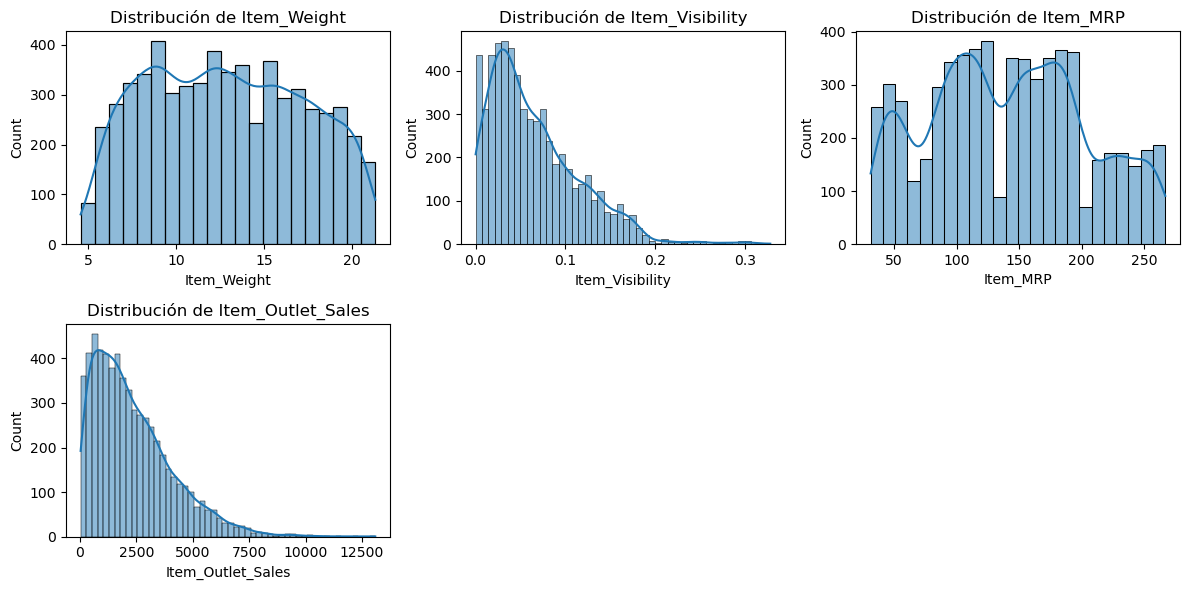

In [27]:
# Visualización inicial
def plot_distributions(df, columns):
    plt.figure(figsize=(12, 6))
    for i, col in enumerate(columns):
        plt.subplot(2, 3, i+1)
        sns.histplot(df[col], kde=True)
        plt.title(f"Distribución de {col}")
    plt.tight_layout()
    plt.show()

plot_distributions(train, ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales'])

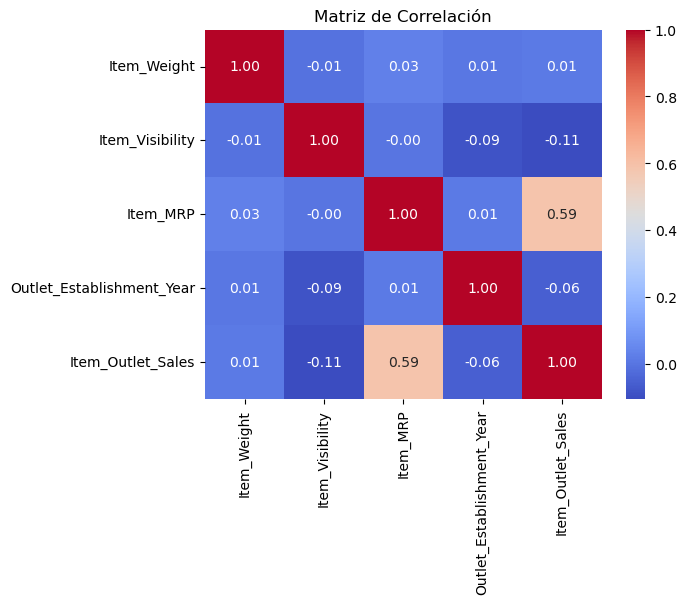

In [28]:
# Filtrar solo las columnas numéricas
numerical_cols = train.select_dtypes(include=['number']).columns

# Visualización de la matriz de correlación solo con columnas numéricas
sns.heatmap(train[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matriz de Correlación")
plt.show()

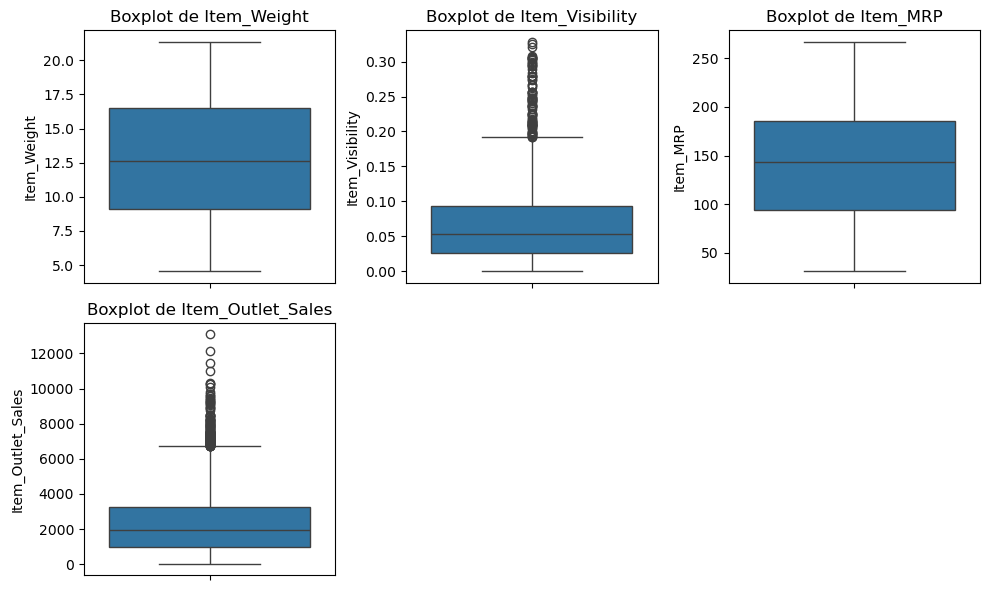

In [29]:
# Boxplots para identificar valores atípicos
def plot_boxplots(df, columns):
    plt.figure(figsize=(10, 6))
    for i, col in enumerate(columns):
        plt.subplot(2, 3, i+1)
        sns.boxplot(y=df[col])
        plt.title(f"Boxplot de {col}")
    plt.tight_layout()
    plt.show()

plot_boxplots(train, ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales'])

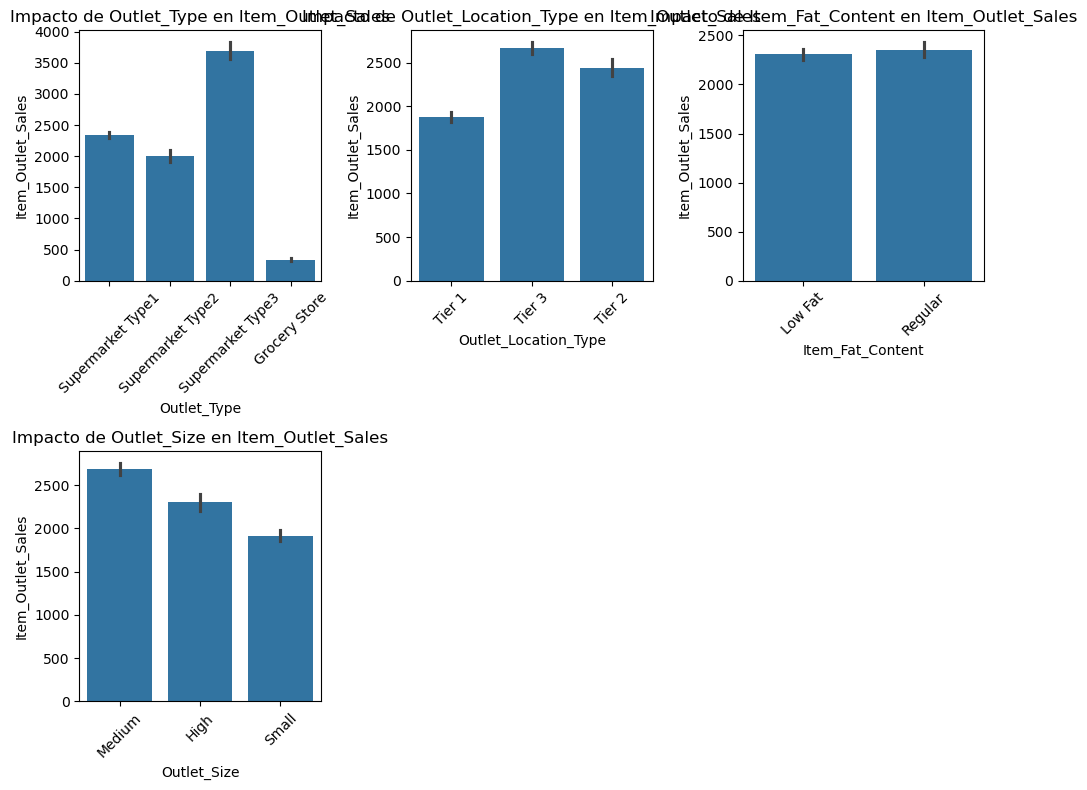

In [30]:
# Análisis de impacto de variables categóricas
def plot_categorical_impact(df, categorical_cols, target_col):
    plt.figure(figsize=(10, 8))
    for i, col in enumerate(categorical_cols):
        plt.subplot(2, 3, i+1)
        sns.barplot(x=df[col], y=df[target_col], estimator=np.mean)
        plt.xticks(rotation=45)
        plt.title(f"Impacto de {col} en {target_col}")
    plt.tight_layout()
    plt.show()

plot_categorical_impact(train, ['Outlet_Type', 'Outlet_Location_Type', 'Item_Fat_Content', 'Outlet_Size'], 'Item_Outlet_Sales')

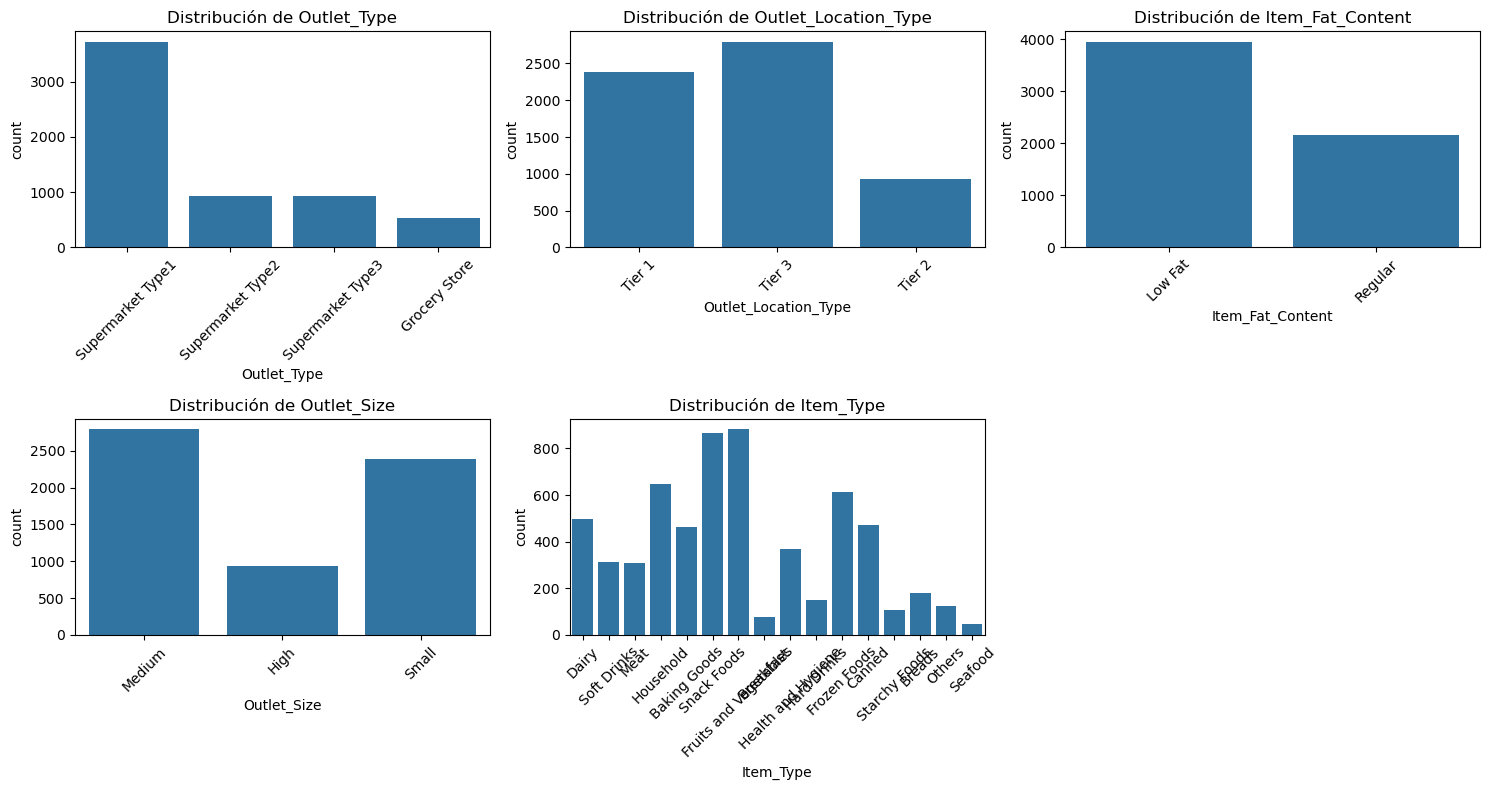

In [31]:
# Distribución de variables categóricas
def plot_categorical_distribution(df, categorical_cols):
    plt.figure(figsize=(15, 8))
    for i, col in enumerate(categorical_cols):
        plt.subplot(2, 3, i+1)
        sns.countplot(x=df[col])
        plt.xticks(rotation=45)
        plt.title(f"Distribución de {col}")
    plt.tight_layout()
    plt.show()

plot_categorical_distribution(train, ['Outlet_Type', 'Outlet_Location_Type', 'Item_Fat_Content', 'Outlet_Size', 'Item_Type'])

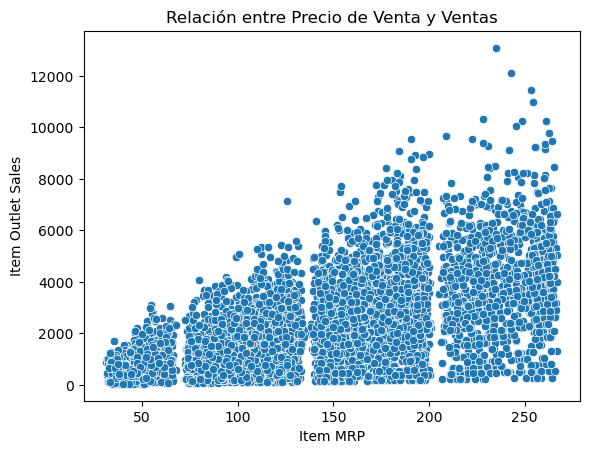

In [32]:
# Relación entre MRP y Ventas
sns.scatterplot(x=train['Item_MRP'], y=train['Item_Outlet_Sales'])
plt.title("Relación entre Precio de Venta y Ventas")
plt.xlabel("Item MRP")
plt.ylabel("Item Outlet Sales")
plt.show()

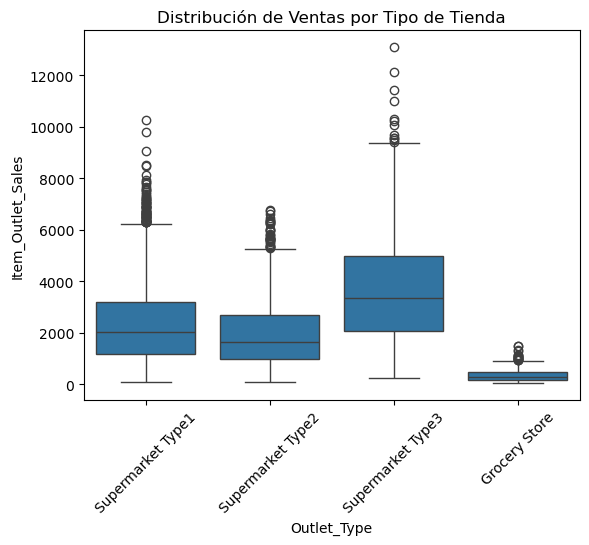

In [33]:
sns.boxplot(x=train['Outlet_Type'], y=train['Item_Outlet_Sales'])
plt.title("Distribución de Ventas por Tipo de Tienda")
plt.xticks(rotation=45)
plt.show()

C:\Users\Lupin III\AppData\Local\Temp\ipykernel_48244\1717346197.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=train_raw['Outlet_Establishment_Year'], y=train_raw['Item_Outlet_Sales'], ci=None, color='red', label='Datos Crudos')
C:\Users\Lupin III\AppData\Local\Temp\ipykernel_48244\1717346197.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=train['Outlet_Establishment_Year'], y=train['Item_Outlet_Sales'], ci=None, color='green', label='Datos Limpios')


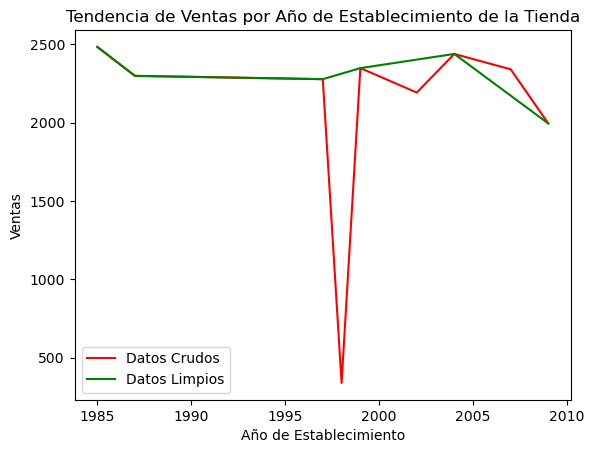

In [34]:
# Tendencia de Ventas según el Año de Establecimiento de la Tienda
sns.lineplot(x=train_raw['Outlet_Establishment_Year'], y=train_raw['Item_Outlet_Sales'], ci=None, color='red', label='Datos Crudos')
sns.lineplot(x=train['Outlet_Establishment_Year'], y=train['Item_Outlet_Sales'], ci=None, color='green', label='Datos Limpios')

# Título y etiquetas
plt.title("Tendencia de Ventas por Año de Establecimiento de la Tienda")
plt.xlabel("Año de Establecimiento")
plt.ylabel("Ventas")

# Mostrar leyenda
plt.legend()

# Mostrar gráfico
plt.show()

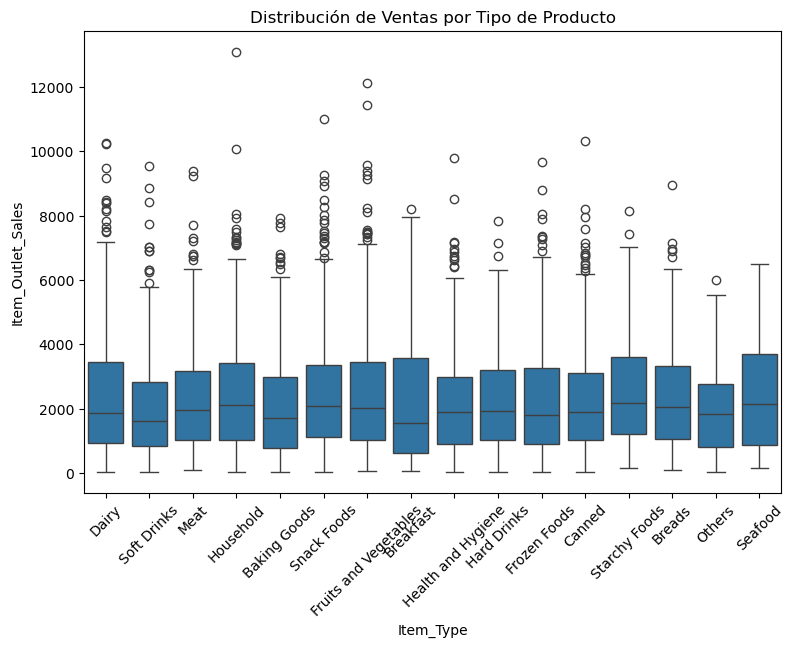

In [35]:
plt.figure(figsize=(9, 6))
sns.boxplot(x=train['Item_Type'], y=train['Item_Outlet_Sales'])
plt.title("Distribución de Ventas por Tipo de Producto")
plt.xticks(rotation=45)
plt.show()

##### Modificacion

NOTA: Pequeña modificacion en la limpieza de los datos, en la pestaña anterior, se ve que hay muchos outliers de una variable, por eso se decide aplicar una limpieza a los datos, con la condicion, de que debe de 'Item_Outlet_Sales', debe de ser menor a 8000, nada de los que sea superior, el cual queda demostrado con el grafico y luego se continua con el analisis.

In [36]:
#Eliminacion de Outliers
train = train[train['Item_Outlet_Sales'] < 7700]

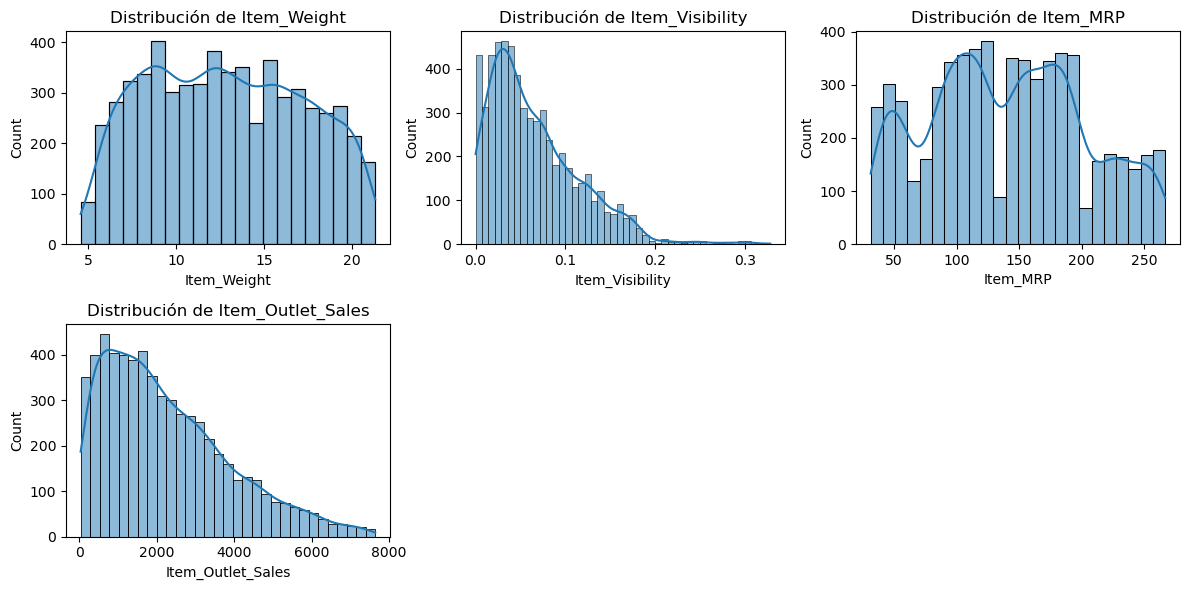

In [37]:
# Visualización inicial
def plot_distributions(df, columns):
    plt.figure(figsize=(12, 6))
    for i, col in enumerate(columns):
        plt.subplot(2, 3, i+1)
        sns.histplot(df[col], kde=True)
        plt.title(f"Distribución de {col}")
    plt.tight_layout()
    plt.show()

plot_distributions(train, ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales'])

In [38]:
# Análisis de Kurtosis
numerical_features = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']

def calculate_kurtosis(df, column):
    return kurtosis(df[column], fisher=True)

print("\nKurtosis de las variables numéricas:")
for col in numerical_features:
    print(f'{col}: {calculate_kurtosis(train, col)}')

# Pruebas estadísticas
# Chi-cuadrado para independencia entre variables categóricas
def chi2_test(df, col1, col2):
    contingency_table = pd.crosstab(df[col1], df[col2])
    stat, p, dof, expected = chi2_contingency(contingency_table)
    return stat, p

# ANOVA para comparación de medias entre grupos
def anova_test(df, numerical_col, categorical_col):
    groups = [df[numerical_col][df[categorical_col] == cat] for cat in df[categorical_col].unique()]
    stat, p = f_oneway(*groups)
    return stat, p

# Aplicación de pruebas estadísticas
test_cat1, test_cat2 = 'Outlet_Size', 'Outlet_Type'
chi2_stat, chi2_p = chi2_test(train, test_cat1, test_cat2)
print(f'Chi2 Test entre {test_cat1} y {test_cat2}: Stat={chi2_stat}, p={chi2_p}')

num_col, cat_col = 'Item_Outlet_Sales', 'Outlet_Type'
anova_stat, anova_p = anova_test(train, num_col, cat_col)
print(f'ANOVA entre {num_col} y {cat_col}: Stat={anova_stat}, p={anova_p}')


Kurtosis de las variables numéricas:
Item_Weight: -1.095967661480813
Item_Visibility: 1.7273052951707202
Item_MRP: -0.8801083690658333
Outlet_Establishment_Year: -1.4441462621663617
Chi2 Test entre Outlet_Size y Outlet_Type: Stat=3677.6424852944424, p=0.0
ANOVA entre Item_Outlet_Sales y Outlet_Type: Stat=510.4260467272786, p=1.0217697068963112e-295


#### Kurtosis

#### Kurtosis de las variables numéricas

La **kurtosis** mide la "concentración" de los datos en las colas de una distribución en comparación con una distribución normal (que tiene una kurtosis de 0 en la definición ajustada, conocida como exceso de kurtosis). Indica si hay muchos valores extremos (colas pesadas) o si la distribución es más plana o puntiaguda.

- **Item_Weight: -1.095967661480813**  
  Un valor negativo indica una distribución **platicúrtica**, es decir, más plana que una normal. Tiene colas más ligeras y menos valores extremos. En este caso, el peso de los ítems tiende a estar más uniformemente distribuido, con pocos valores muy altos o muy bajos.

- **Item_Visibility: 1.7273052951707202**  
  Un valor positivo indica una distribución **leptocúrtica**, más puntiaguda que una normal. Tiene colas más pesadas, lo que significa que hay más valores extremos. La visibilidad de los ítems varía mucho, con algunos ítems teniendo visibilidad muy alta o muy baja.

- **Item_MRP: -0.8801083690658333**  
  Similar a `Item_Weight`, es platicúrtica (negativa). El precio máximo de venta al público (MRP) tiene una distribución más plana, con menos valores extremos y más uniformidad en los precios.

- **Outlet_Establishment_Year: -1.4441462621663617**  
  También platicúrtica, y con un valor más negativo, lo que sugiere una distribución aún más plana. Los años de establecimiento de las tiendas no tienen muchos valores extremos, probablemente distribuidos de manera más uniforme en un rango.

---

#### Chi2 Test entre Outlet_Size y Outlet_Type

El **test de Chi-cuadrado (Chi2)** se usa para evaluar si hay una relación significativa entre dos variables categóricas.

- **Stat = 3677.6424852944424, p = 0.0**  
  - **Stat**: El valor del estadístico Chi2. Cuanto más alto, mayor es la evidencia de una relación entre las variables.  
  - **p = 0.0**: El valor p indica la probabilidad de que la relación observada sea por azar. Un valor de 0.0 (o muy cercano a 0) significa que la relación entre `Outlet_Size` (tamaño de la tienda) y `Outlet_Type` (tipo de tienda) es **estadísticamente significativa**. Es decir, el tamaño de la tienda depende del tipo de tienda (por ejemplo, supermercados grandes frente a tiendas pequeñas).

---

#### ANOVA entre Item_Outlet_Sales y Outlet_Type

El **ANOVA (Análisis de Varianza)** evalúa si hay diferencias significativas en una variable numérica (como `Item_Outlet_Sales`) entre grupos definidos por una variable categórica (como `Outlet_Type`).

- **Stat = 510.4260467272786, p = 1.021769706896311e-295**  
  - **Stat**: El valor F del ANOVA. Un valor alto sugiere diferencias grandes entre los grupos.  
  - **p = 1.021769706896311e-295**: Un valor p extremadamente pequeño (prácticamente 0) indica que las diferencias en las ventas (`Item_Outlet_Sales`) entre los diferentes tipos de tiendas (`Outlet_Type`) son **estadísticamente significativas**. En otras palabras, el tipo de tienda tiene un impacto claro en las ventas.

---

#### Interpretación general

- **Kurtosis**: Las variables numéricas tienen distribuciones variadas. `Item_Visibility` tiene más valores extremos, mientras que `Item_Weight`, `Item_MRP` y `Outlet_Establishment_Year` son más uniformes.  
- **Chi2**: Hay una relación fuerte entre el tamaño de la tienda y su tipo.  
- **ANOVA**: El tipo de tienda influye significativamente en las ventas de los ítems.

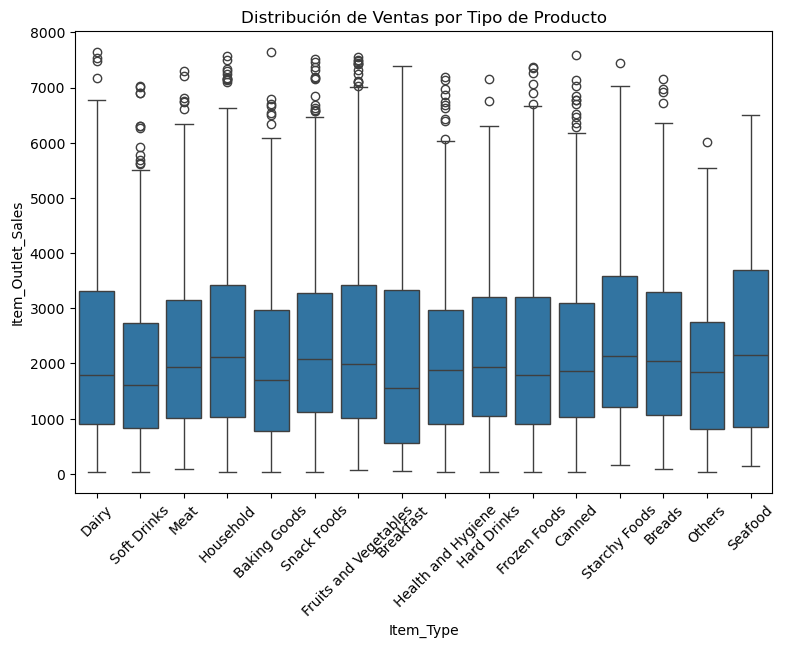

In [39]:
plt.figure(figsize=(9, 6))
sns.boxplot(x=train['Item_Type'], y=train['Item_Outlet_Sales'])
plt.title("Distribución de Ventas por Tipo de Producto")
plt.xticks(rotation=45)
plt.show()

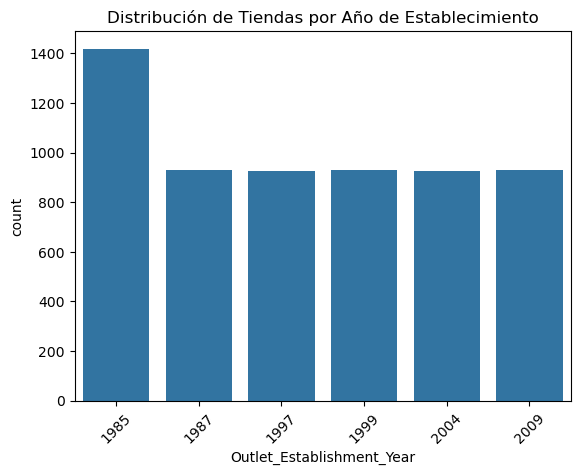

Comparacion con datos limpios vs datos crudos


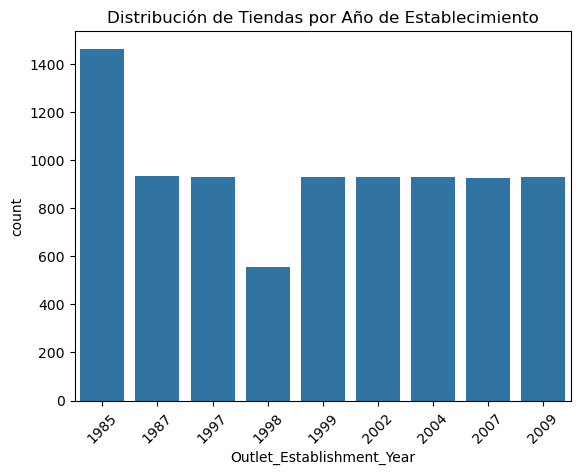

In [40]:
sns.countplot(x=train['Outlet_Establishment_Year'])
plt.title("Distribución de Tiendas por Año de Establecimiento")
plt.xticks(rotation=45)
plt.show()

print("Comparacion con datos limpios vs datos crudos")

sns.countplot(x=train_raw['Outlet_Establishment_Year'])
plt.title("Distribución de Tiendas por Año de Establecimiento")
plt.xticks(rotation=45)
plt.show()

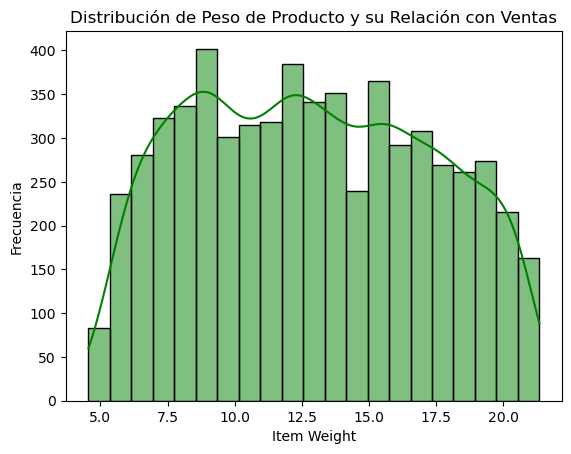

In [41]:
sns.histplot(train['Item_Weight'], kde=True, color='green')
plt.title("Distribución de Peso de Producto y su Relación con Ventas")
plt.xlabel("Item Weight")
plt.ylabel("Frecuencia")
plt.show()

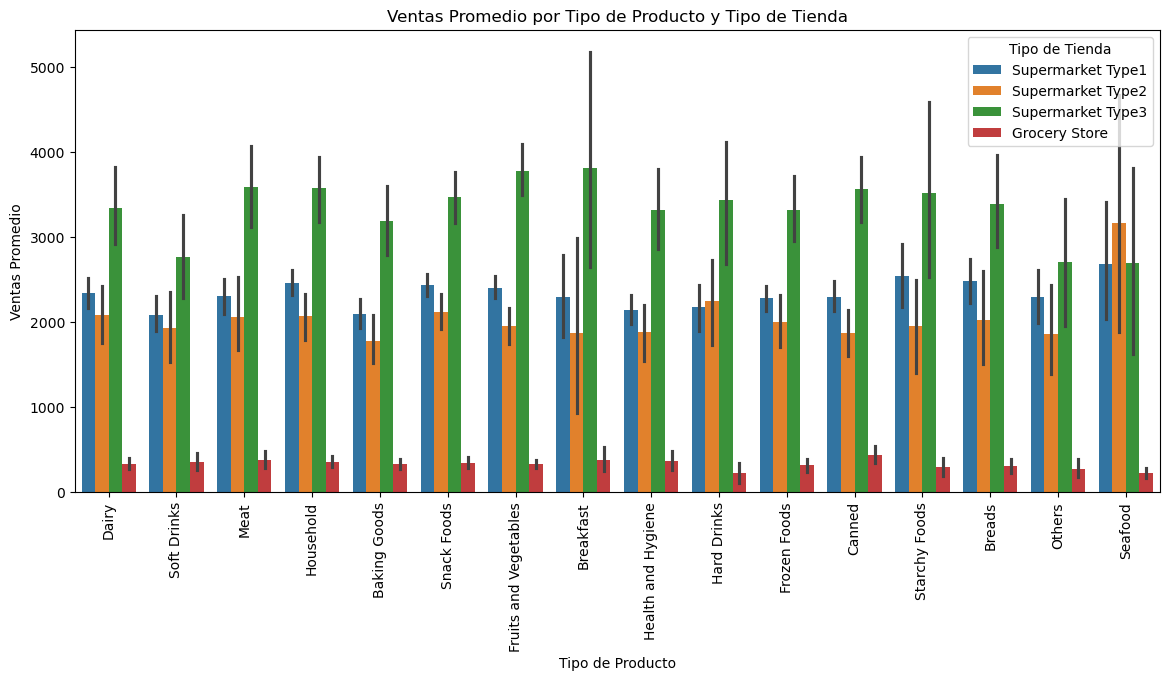

In [42]:
plt.figure(figsize=(14, 6))
sns.barplot(x=train['Item_Type'], y=train['Item_Outlet_Sales'], hue=train['Outlet_Type'], estimator=np.mean)
plt.title("Ventas Promedio por Tipo de Producto y Tipo de Tienda")
plt.xlabel("Tipo de Producto")
plt.ylabel("Ventas Promedio")
plt.xticks(rotation=90)
plt.legend(title="Tipo de Tienda")
plt.show()

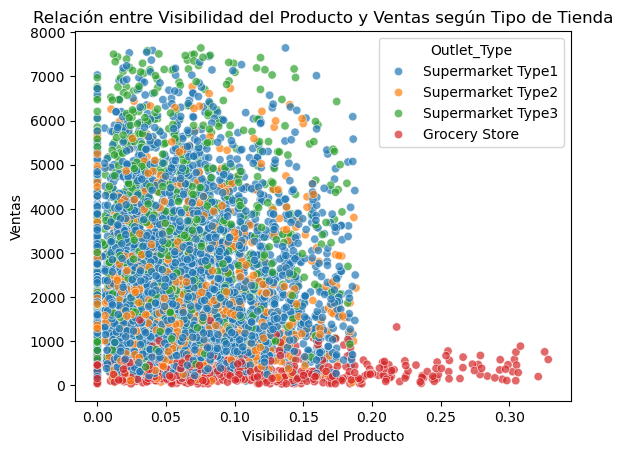

In [43]:
sns.scatterplot(x=train['Item_Visibility'], y=train['Item_Outlet_Sales'], hue=train['Outlet_Type'], alpha=0.7)
plt.title("Relación entre Visibilidad del Producto y Ventas según Tipo de Tienda")
plt.xlabel("Visibilidad del Producto")
plt.ylabel("Ventas")
plt.show()

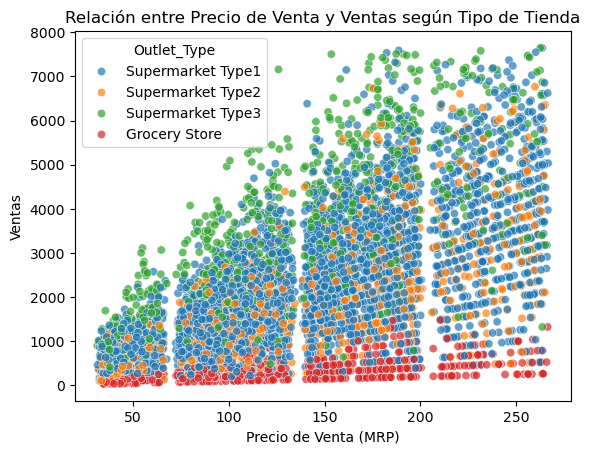

In [44]:
sns.scatterplot(x=train['Item_MRP'], y=train['Item_Outlet_Sales'], hue=train['Outlet_Type'], alpha=0.7)
plt.title("Relación entre Precio de Venta y Ventas según Tipo de Tienda")
plt.xlabel("Precio de Venta (MRP)")
plt.ylabel("Ventas")
plt.show()

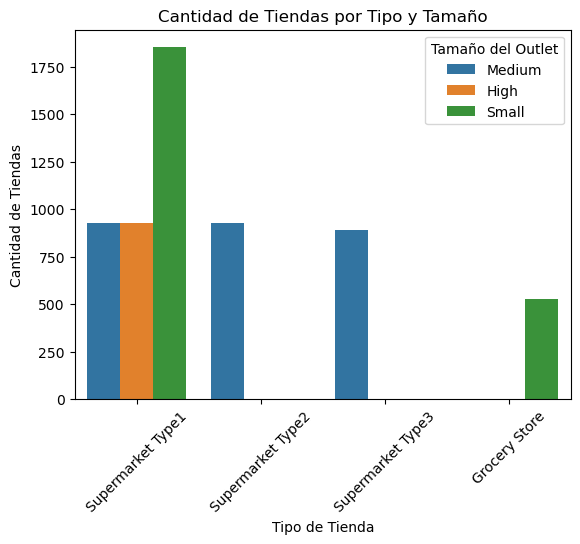

In [45]:
sns.countplot(x=train['Outlet_Type'], hue=train['Outlet_Size'])
plt.title("Cantidad de Tiendas por Tipo y Tamaño")
plt.xlabel("Tipo de Tienda")
plt.ylabel("Cantidad de Tiendas")
plt.xticks(rotation=45)
plt.legend(title="Tamaño del Outlet")
plt.show()

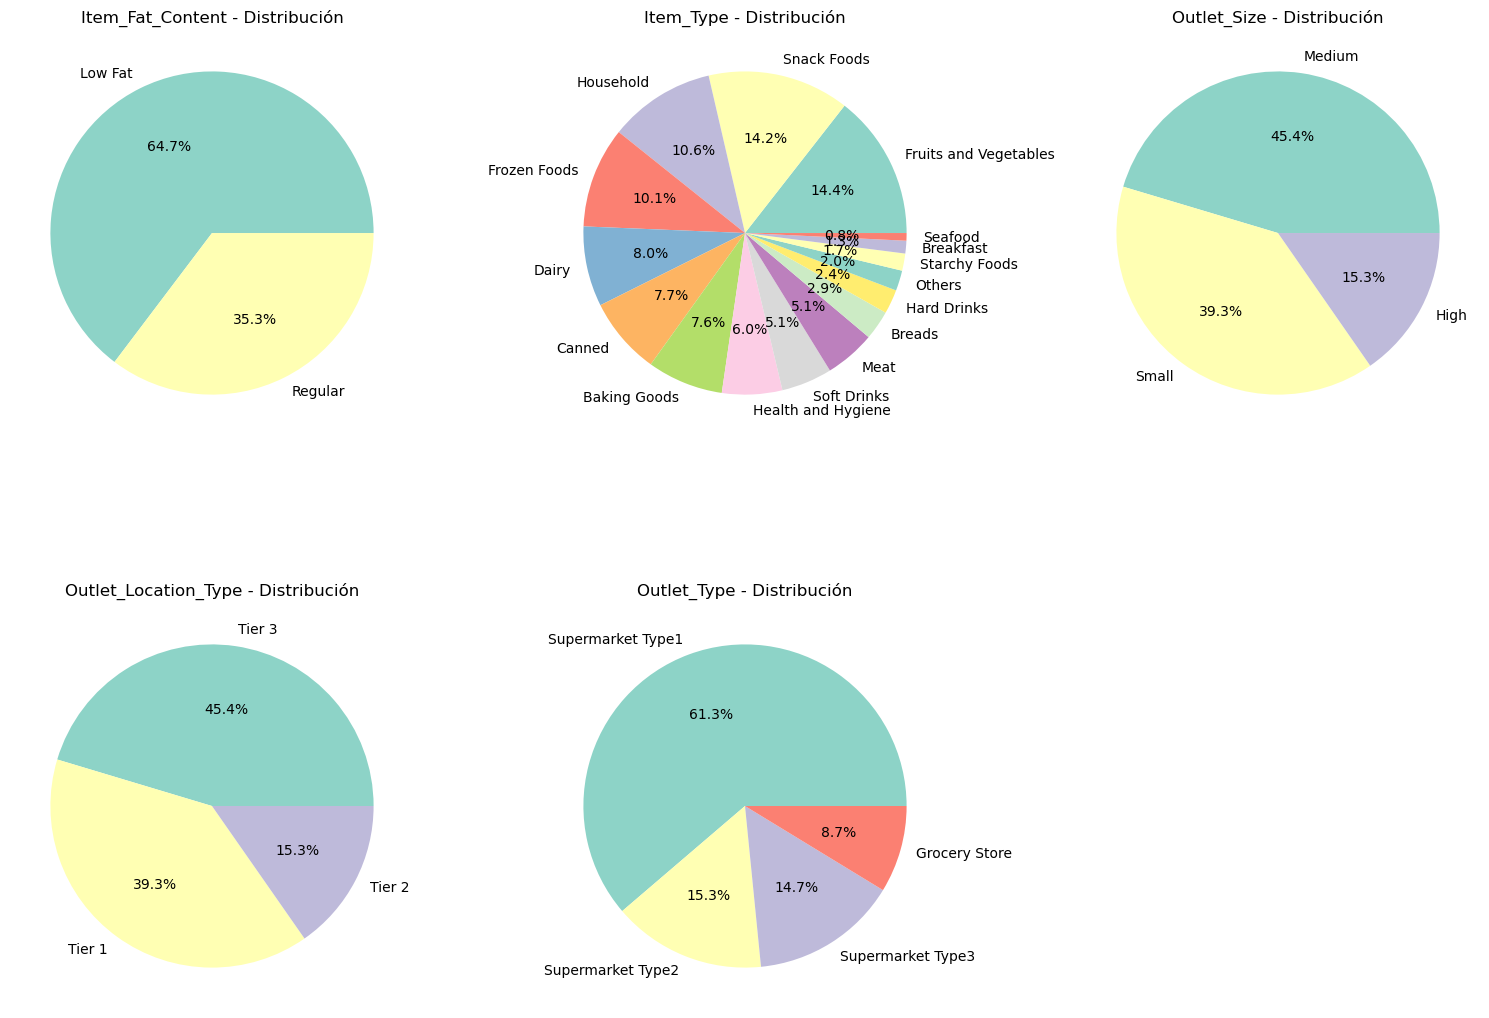

In [46]:
# Variables categóricas
categorical_columns = ['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']

# Configurar el tamaño general del gráfico
plt.figure(figsize=(15, 12))

# Crear un gráfico de torta para cada variable categórica
for idx, col in enumerate(categorical_columns, 1):
    plt.subplot(2, 3, idx)  
    data = train[col].value_counts(dropna=False)  
    plt.pie(data, labels=data.index, autopct='%1.1f%%', colors=sns.color_palette('Set3', len(data)))  
    plt.title(f'{col} - Distribución')  

# Ajustar el espacio entre los gráficos
plt.tight_layout()
plt.show()

In [47]:
# Función para detectar outliers en una columna
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Iterar sobre las características numéricas y detectar outliers en train y test
for col in numerical_features:
    # Detectar outliers en el dataset train
    outliers_train = detect_outliers(train, col)
    print(f"Outliers en {col} (train): {outliers_train.shape[0]}")
    
    # Detectar outliers en el dataset test
    outliers_test = detect_outliers(test, col)
    print(f"Outliers en {col} (test): {outliers_test.shape[0]}")

Outliers en Item_Weight (train): 0
Outliers en Item_Weight (test): 0
Outliers en Item_Visibility (train): 81
Outliers en Item_Visibility (test): 57
Outliers en Item_MRP (train): 0
Outliers en Item_MRP (test): 0
Outliers en Outlet_Establishment_Year (train): 0
Outliers en Outlet_Establishment_Year (test): 0


In [48]:
# Función para detectar y eliminar outliers en una columna
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Filtrar los datos que no son outliers
    df_clean = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_clean

# Iterar sobre las características numéricas y eliminar outliers en train y test
for col in numerical_features:
    # Eliminar outliers en el dataset train
    train = remove_outliers(train, col)
    print(f"Filtrado de outliers en {col} (train). Número de registros restantes: {train.shape[0]}")
    
    # Eliminar outliers en el dataset test
    test = remove_outliers(test, col)
    print(f"Filtrado de outliers en {col} (test). Número de registros restantes: {test.shape[0]}")

Filtrado de outliers en Item_Weight (train). Número de registros restantes: 6059
Filtrado de outliers en Item_Weight (test). Número de registros restantes: 4075
Filtrado de outliers en Item_Visibility (train). Número de registros restantes: 5978
Filtrado de outliers en Item_Visibility (test). Número de registros restantes: 4018
Filtrado de outliers en Item_MRP (train). Número de registros restantes: 5978
Filtrado de outliers en Item_MRP (test). Número de registros restantes: 4018
Filtrado de outliers en Outlet_Establishment_Year (train). Número de registros restantes: 5978
Filtrado de outliers en Outlet_Establishment_Year (test). Número de registros restantes: 4018


**NOTA**: 

La limpieza de datos se realizó en función de la detección de outliers utilizando la metodología de los cuartiles. Los datos categóricos con outliers fueron eliminados, lo cual no afectará significativamente los resultados derivados de dichos datos. 

En cuanto a los datos lineales, los outliers fueron reemplazados mediante interpolación lineal.

Este formato es más claro y estructurado.

### Procesamiento de datos:

- Selección de variables importantes para el modelo
- Feature engineering para variables numéricas, categóricas y datetimes

In [49]:
#Agrego nuevas variables con Feature Engineering
def feature_engineering(df):
    df['Price_per_Weight'] = df['Item_MRP'] / (df['Item_Weight'] + 1e-3)
    df['MRP_Visibility_Interaction'] = df['Item_MRP'] * df['Item_Visibility']
    return df

train = feature_engineering(train)
test = feature_engineering(test)

#### Explicación de las variables

##### Análisis de las Variables Agregadas

1. **Price_per_Weight**:
    - ***Cálculo***: `Item_MRP / (Item_Weight + 1e-3)`
    - ***Descripción***: Representa el precio por unidad de peso del producto. Los consumidores pueden comparar productos similares en términos de precio por gramo, lo que podría influir en su decisión de compra. Este valor también puede reflejar la calidad percibida o la relación calidad-precio.

2. **MRP_Visibility_Interaction**:
    - ***Cálculo***: `Item_MRP * Item_Visibility`
    - ***Descripción***: Captura la interacción entre el precio y la visibilidad del producto. Los productos más visibles y costosos pueden comportarse de manera diferente en términos de ventas en comparación con los productos menos visibles o más baratos. Esta variable ayuda a modelar cómo estas dos características pueden influir juntas en las ventas.

##### Variables Agregadas y Posteriormente Descartadas

1. ****Outlet_Age***:
    - ***Cálculo***: `2025 - Outlet_Establishment_Year`
    - ***Descripción***: Representa la antigüedad de la tienda en años, lo que puede influir en la confianza del cliente y la estabilidad de las ventas. Una tienda más antigua podría tener una base de clientes más leal y estable, lo que afectaría sus ventas.
    - ***Motivo de descarte***: Ya contaba con el año en la variable original.

2. ***Item_Visibility_Squared***:
    - ***Cálculo***: `Item_Visibility ** 2`
    - ***Descripción***: Captura efectos no lineales en la visibilidad del producto. La relación entre la visibilidad y las ventas podría no ser estrictamente lineal, y esta variable ayuda a modelar relaciones más complejas donde los efectos de visibilidad podrían crecer de manera exponencial.
    - ***Motivo de descarte***: La relación lineal entre las ventas no era significativa.


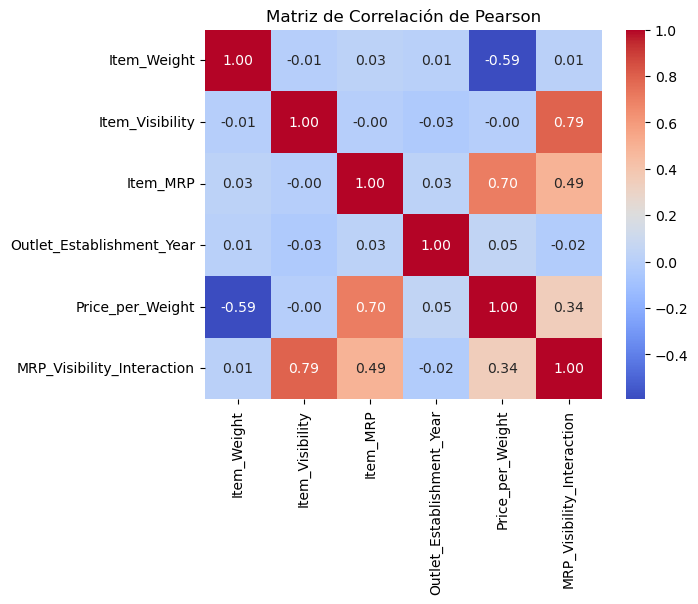

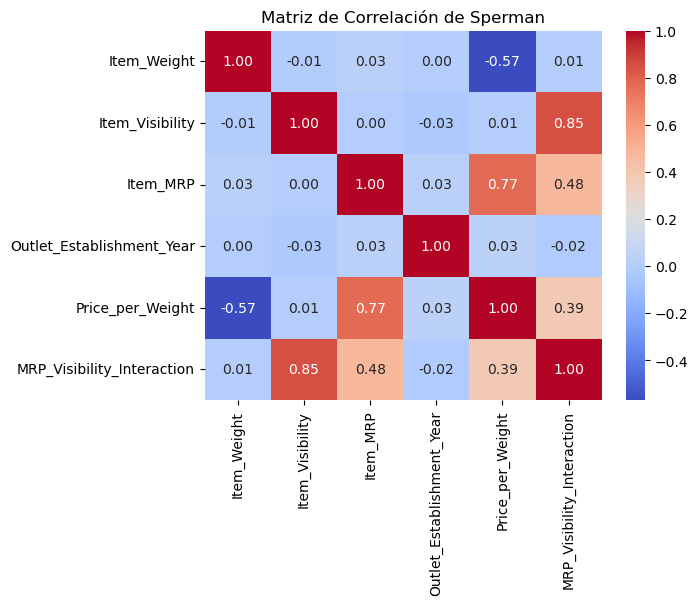

In [50]:
#Agregar los nuevos datos

new_features = ['Price_per_Weight', 'MRP_Visibility_Interaction']
for feature in new_features:
    if feature not in numerical_features:
        numerical_features.append(feature)

# Matriz de correlación de Pearson
corr_matrix = train[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matriz de Correlación de Pearson")
plt.show()


# Matriz de correlación de Sperman
corr_matrix = train[numerical_features].corr(method="spearman")
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matriz de Correlación de Sperman")
plt.show()

### Preprocesamiento de datos


In [51]:
# Definición de features
numerical_features = [ 'Item_Weight','Item_Visibility','Item_MRP','Outlet_Establishment_Year','Price_per_Weight','MRP_Visibility_Interaction']

categorical_features = ['Item_Fat_Content', 'Item_Type', 'Outlet_Size','Outlet_Location_Type', 'Outlet_Type']

# One-Hot Encoding
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoded_train = encoder.fit_transform(train[categorical_features])
encoded_test = encoder.transform(test[categorical_features])

# Normalización
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train[numerical_features])
scaled_test = scaler.transform(test[numerical_features])

### Entrenamiento & Modelado de datos

In [52]:
X_train = np.hstack((scaled_train, encoded_train))
X_test = np.hstack((scaled_test, encoded_test))
y_train = train['Item_Outlet_Sales'].values

In [53]:
print(f"Shape X_train: {X_train.shape}")
print(f"Shape X_test: {X_test.shape}")

Shape X_train: (5978, 29)
Shape X_test: (4018, 29)


In [54]:
# Dividir datos
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

In [55]:
## Random Forest
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42)

In [56]:
## XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=200, max_depth=10, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [57]:
## Red Neuronal
nn_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
])
nn_model.compile(optimizer='adam', loss='mse')
nn_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

C:\Users\Lupin III\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


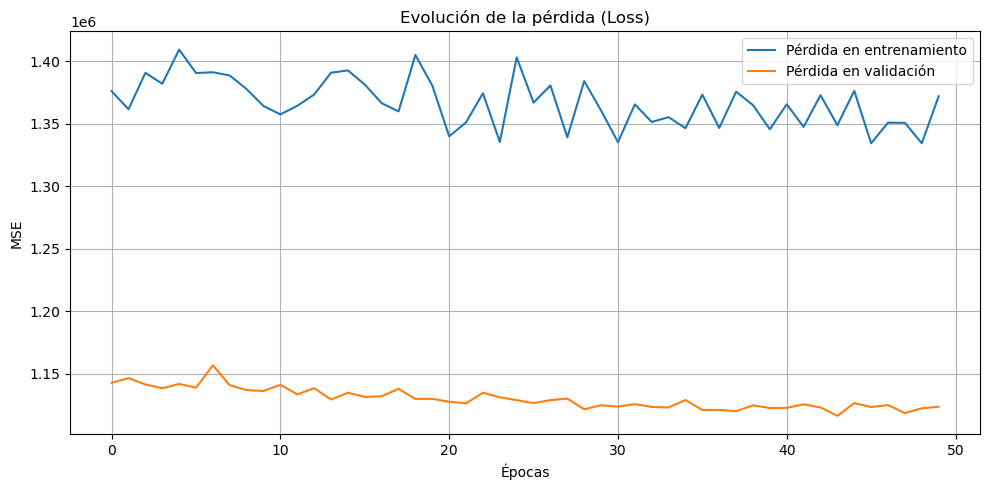

In [58]:
history = nn_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    verbose=0,
    validation_data=(X_val, y_val)
)

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Evolución de la pérdida (Loss)')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [59]:
## Regresión Lineal
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [60]:
# LightGBM
lgbm = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, max_depth=-1, num_leaves=31, subsample=0.8,
    colsample_bytree=0.8, random_state=42,n_jobs=-1)
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1319
[LightGBM] [Info] Number of data points in the train set: 5978, number of used features: 29
[LightGBM] [Info] Start training from score 2289.994376


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, n_estimators=1000,
              n_jobs=-1, random_state=42, subsample=0.8)

In [61]:
#Gradient Boosting Machine (GBM)
gbm = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, subsample=0.8, max_features='sqrt',
    random_state=42)
gbm.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=4, max_features='sqrt',
                          n_estimators=500, random_state=42, subsample=0.8)

In [62]:
#Support Vector Machine (SVM)
svm = SVR()
svm.fit(X_train, y_train)

SVR()

In [63]:
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    rmse = mean_squared_error(y, y_pred, squared=False)
    mse = mean_squared_error(y, y_pred)  
    r2 = r2_score(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred)
    return rmse, mse, r2, mape

In [64]:
print("\nEvaluación de Modelos:")

for name, model in zip(['Random Forest', 'XGBoost', 'Red Neuronal','Regresion Lineal', "LightGBM","Gradient Boosting Machine","Support Vector Machine"], [rf_model, xgb_model, nn_model,lr_model,lgbm, gbm, svm ]):
    mse, rmse, r2, mape_train = evaluate_model(model, X_train, y_train)
    print(f'{name} (Train): MSE={mse}, RMSE={rmse}, R2={r2}, MAPE={mape_train}')


Evaluación de Modelos:
Random Forest (Train): MSE=873.9533395393837, RMSE=763794.4396920414, R2=0.7111684250532426, MAPE=0.4376600247274927
XGBoost (Train): MSE=227.05177498788808, RMSE=51552.50852515056, R2=0.9805052361525715, MAPE=0.12709460213637902
  1/187 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Red Neuronal (Train): MSE=1067.472067059972, RMSE=1139496.6139532896, R2=0.5690953160285813, MAPE=0.5263114506232104
Regresion Lineal (Train): MSE=1086.4728353189123, RMSE=1180423.2218859165, R2=0.5536187741580025, MAPE=0.8410084825963055
LightGBM (Train): MSE=573.0682300213429, RMSE=328407.1962597947, R2=0.8758116545626985, MAPE=0.33817524701096496


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Gradient Boosting Machine (Train): MSE=900.699895918029, RMSE=811260.3025067482, R2=0.693219040767981, MAPE=0.5187739193337977
Support Vector Machine (Train): MSE=1560.3152730120735, RMSE=2434583.751194741, R2=0.07935352412242902, MAPE=1.3801590431289308


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [65]:
def check_overfitting(train_r2, val_r2, threshold=0.15):
    """Detecta overfitting basado en la diferencia de R2 entre train y validation"""
    diff = train_r2 - val_r2
    if diff > threshold:
        return f"🚨 OVERFITTING (Diferencia R2: {diff:.2f})"
    elif val_r2 < 0.5:  # Umbral para underfitting
        return "🚨 UNDERFITTING (R2 bajo en validación)"
    elif diff < 0.05:
        return "✅ Modelo bien ajustado"
    else:
        return "⚠️ Pequeño overfitting"

print("\nEvaluación de Modelos:")

# Asumiendo que tienes X_val y y_val definidos
for name, model in zip(['Random Forest', 'XGBoost', 'Red Neuronal', 'Regresion Lineal', 
                       "LightGBM", "Gradient Boosting Machine", "Support Vector Machine"], 
                      [rf_model, xgb_model, nn_model, lr_model, lgbm, gbm, svm]):
    
    # Asegurarse que el modelo está entrenado
    if not hasattr(model, 'fit_'):
        model.fit(X_train, y_train)
    
    # Evaluación en train
    rmse_train, mse_train, r2_train, mape_train = evaluate_model(model, X_train, y_train)
    
    # Evaluación en validation
    rmse_val, mse_val, r2_val, mape_val = evaluate_model(model, X_val, y_val)
    
    # Resultados
    print(f"\n{name}:")
    print(f"  TRAIN -> MSE: {mse_train:.2f} | RMSE: {rmse_train:.2f} | R2: {r2_train:.3f} | MAPE: {mape_train:.2f}%")
    print(f"  VAL   -> MSE: {mse_val:.2f} | RMSE: {rmse_val:.2f} | R2: {r2_val:.3f} | MAPE: {mape_val:.2f}%")
    
    # Diagnóstico
    diagnosis = check_overfitting(r2_train, r2_val)
    print(f"  {diagnosis}")
    print("-"*70)


Evaluación de Modelos:


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Random Forest:
  TRAIN -> MSE: 763794.44 | RMSE: 873.95 | R2: 0.711 | MAPE: 0.44%
  VAL   -> MSE: 775281.15 | RMSE: 880.50 | R2: 0.694 | MAPE: 0.45%
  ✅ Modelo bien ajustado
----------------------------------------------------------------------

XGBoost:
  TRAIN -> MSE: 51552.51 | RMSE: 227.05 | R2: 0.981 | MAPE: 0.13%
  VAL   -> MSE: 54286.14 | RMSE: 232.99 | R2: 0.979 | MAPE: 0.13%
  ✅ Modelo bien ajustado
----------------------------------------------------------------------
 19/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1504354.3750 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1397846.0000
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Red Neuronal:
  TRAIN -> MSE: 1142404.42 | RMSE: 1068.83 | R2: 0.568 | MAPE: 0.52%
  VAL   -> MSE: 1124955.29 | RMSE: 1060.64 | R2: 0.557 | MAPE: 0.54%
  ✅ Modelo bien ajustado
----------------------------------------------------------------------

Regresion Lineal:
  TRAIN -> MSE: 1180423.22 | RMSE: 1086.47 | R2: 0.554 | MAPE: 0.84%
  VAL   -> MSE: 1167886.60 | RMSE: 1080.69 | R2: 0.540 | MAPE: 0.85%
  ✅ Modelo bien ajustado
----------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1319
[LightGBM] [Info] Number of data points in the train set: 5978, number of used features: 29
[LightGBM] [Info] Start training from score 2289.994376


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 


LightGBM:
  TRAIN -> MSE: 328407.20 | RMSE: 573.07 | R2: 0.876 | MAPE: 0.34%
  VAL   -> MSE: 336214.62 | RMSE: 579.84 | R2: 0.867 | MAPE: 0.35%
  ✅ Modelo bien ajustado
----------------------------------------------------------------------


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Gradient Boosting Machine:
  TRAIN -> MSE: 811260.30 | RMSE: 900.70 | R2: 0.693 | MAPE: 0.52%
  VAL   -> MSE: 820999.03 | RMSE: 906.09 | R2: 0.676 | MAPE: 0.54%
  ✅ Modelo bien ajustado
----------------------------------------------------------------------


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Support Vector Machine:
  TRAIN -> MSE: 2434583.75 | RMSE: 1560.32 | R2: 0.079 | MAPE: 1.38%
  VAL   -> MSE: 2301678.87 | RMSE: 1517.13 | R2: 0.093 | MAPE: 1.39%
  🚨 UNDERFITTING (R2 bajo en validación)
----------------------------------------------------------------------


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Evaluación de Modelos:
Random Forest (Train): MSE=763794.4396920414, RMSE=873.9533395393837, R2=0.7111684250532426, MAPE=43.76600247274927
XGBoost (Train): MSE=51552.50852515056, RMSE=227.05177498788808, R2=0.9805052361525715, MAPE=12.709460213637902
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Red Neuronal (Train): MSE=1142404.4152531268, RMSE=1068.8332027276879, R2=0.5679957206591743, MAPE=52.1638801618039
Regresión Lineal (Train): MSE=1180423.2218859165, RMSE=1086.4728353189123, R2=0.5536187741580025, MAPE=84.10084825963054
LightGBM (Train): MSE=328407.1962597947, RMSE=573.0682300213429, R2=0.8758116545626985, MAPE=33.817524701096495
Gradient Boosting Machine (Train): MSE=811260.3025067482, RMSE=900.699895918029, R2=0.693219040767981, MAPE=51.87739193337977
Support Vector Machine (Train): MSE=2434583.751194741, RMSE=1560.3152730120735, R2=0.07935352412242902, MAPE=138.01590431289307


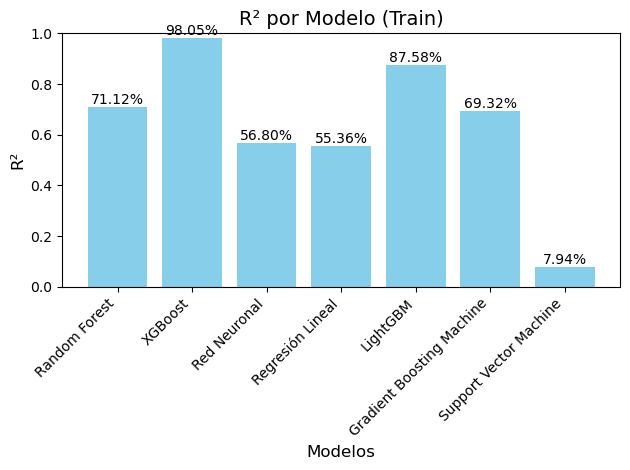

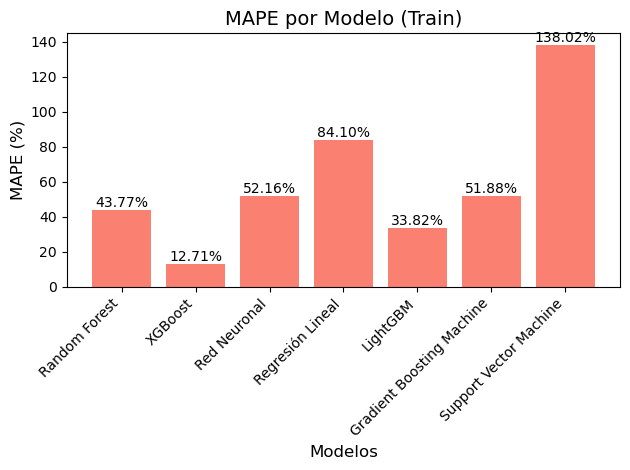

In [66]:
# Lista de nombres de modelos
model_names = ['Random Forest', 'XGBoost', 'Red Neuronal', 'Regresión Lineal', 
               'LightGBM', 'Gradient Boosting Machine', 'Support Vector Machine']

# Modelos
models = [rf_model, xgb_model, nn_model, lr_model, lgbm, gbm, svm]

# Función evaluate_model ajustada
def evaluate_model(model, X_train, y_train):
    y_pred = model.predict(X_train)
    
    if y_train.ndim > 1:
        y_train = y_train.flatten()
    if y_pred.ndim > 1:
        y_pred = y_pred.flatten()
    mse = np.mean((y_train - y_pred) ** 2)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_train, y_pred)
    mape = np.mean(np.abs((y_train - y_pred) / y_train)) * 100
    return mse, rmse, r2, mape

# Evaluación de modelos y almacenamiento de resultados
r2_scores = []
mape_scores = []

print("\nEvaluación de Modelos:")
for name, model in zip(model_names, models):
    mse, rmse, r2, mape_train = evaluate_model(model, X_train, y_train)
    print(f'{name} (Train): MSE={mse}, RMSE={rmse}, R2={r2}, MAPE={mape_train}')
    r2_scores.append(r2)
    mape_scores.append(mape_train)

# Gráfico de R² con porcentajes

bars = plt.bar(model_names, r2_scores, color='skyblue')
plt.title('R² por Modelo (Train)', fontsize=14)
plt.xlabel('Modelos', fontsize=12)
plt.ylabel('R²', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

# Agregar porcentajes encima de las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2%}', 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Gráfico de MAPE con porcentajes

bars = plt.bar(model_names, mape_scores, color='salmon')
plt.title('MAPE por Modelo (Train)', fontsize=14)
plt.xlabel('Modelos', fontsize=12)
plt.ylabel('MAPE (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Agregar porcentajes encima de las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

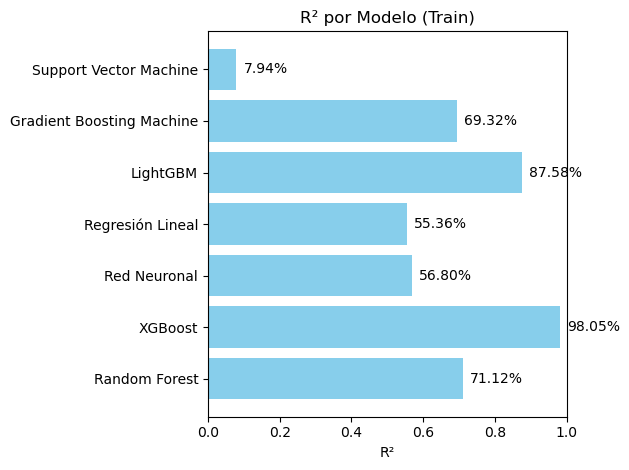

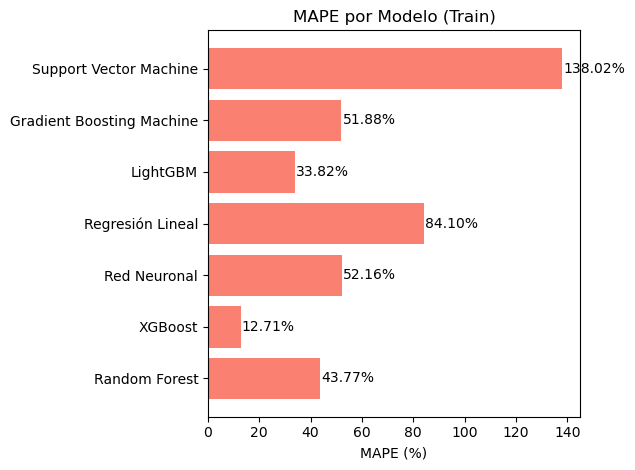

In [67]:
# Gráfico R² horizontal
bars = plt.barh(model_names, r2_scores, color='skyblue')
plt.title('R² por Modelo (Train)')
plt.xlabel('R²')
plt.xlim(0, 1)
for bar in bars:
    plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2%}', 
             ha='left', va='center')
plt.tight_layout()
plt.show()

# Gráfico MAPE horizontal
bars = plt.barh(model_names, mape_scores, color='salmon')
plt.title('MAPE por Modelo (Train)')
plt.xlabel('MAPE (%)')
for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}%', 
             ha='left', va='center')
plt.tight_layout()
plt.show()

#### Nota:
Luego de este análisis, se observan dos cosas:
- La primera es que no hay *underfitting* ni *overfitting*.
- Los tres modelos que mejor rendimiento presentan son **XGBoost**, **RandomForest** y **LightGBM**.

In [68]:
# Validación Cruzada de los 3 modelos mas importantes
def evaluate_with_cv(model, X, y):
    neg_mse_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    rmse = np.mean(np.sqrt(-neg_mse_scores))
    y_pred = cross_val_predict(model, X, y, cv=5)
    
    r2 = r2_score(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred)
    
    return rmse, r2, mape

# Evaluar el modelo Random Forest
rf_rmse_cv, rf_r2_cv, rf_mape_cv = evaluate_with_cv(rf_model, X_train, y_train)
print(f'Random Forest CV RMSE: {rf_rmse_cv:.4f}')
print(f'Random Forest CV R2: {rf_r2_cv:.4f}')
print(f'Random Forest CV MAPE: {rf_mape_cv:.4f}')

# Evaluar el modelo XGBoost
xgb_model = XGBRegressor()
xgb_rmse_cv, xgb_r2_cv, xgb_mape_cv = evaluate_with_cv(xgb_model, X_train, y_train)
print(f'XGBoost CV RMSE: {xgb_rmse_cv:.4f}')
print(f'XGBoost CV R2: {xgb_r2_cv:.4f}')
print(f'XGBoost CV MAPE: {xgb_mape_cv:.4f}')

# Evaluar el modelo LightGBM
lgbm_model = LGBMRegressor()
lgbm_rmse_cv, lgbm_r2_cv, lgbm_mape_cv = evaluate_with_cv(lgbm_model, X_train, y_train)
print(f'LightGBM CV RMSE: {lgbm_rmse_cv:.4f}')
print(f'LightGBM CV R2: {lgbm_r2_cv:.4f}')
print(f'LightGBM CV MAPE: {lgbm_mape_cv:.4f}')

Random Forest CV RMSE: 1082.6852
Random Forest CV R2: 0.5566
Random Forest CV MAPE: 0.5535
XGBoost CV RMSE: 1183.7568
XGBoost CV R2: 0.4701
XGBoost CV MAPE: 0.6292
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1318
[LightGBM] [Info] Number of data points in the train set: 4782, number of used features: 29
[LightGBM] [Info] Start training from score 2286.542100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1320
[LightGBM] [Info] Number of data points in the train set: 4782, number of used features: 29
[LightGBM] [Info] Start training from score 2296.230589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove 

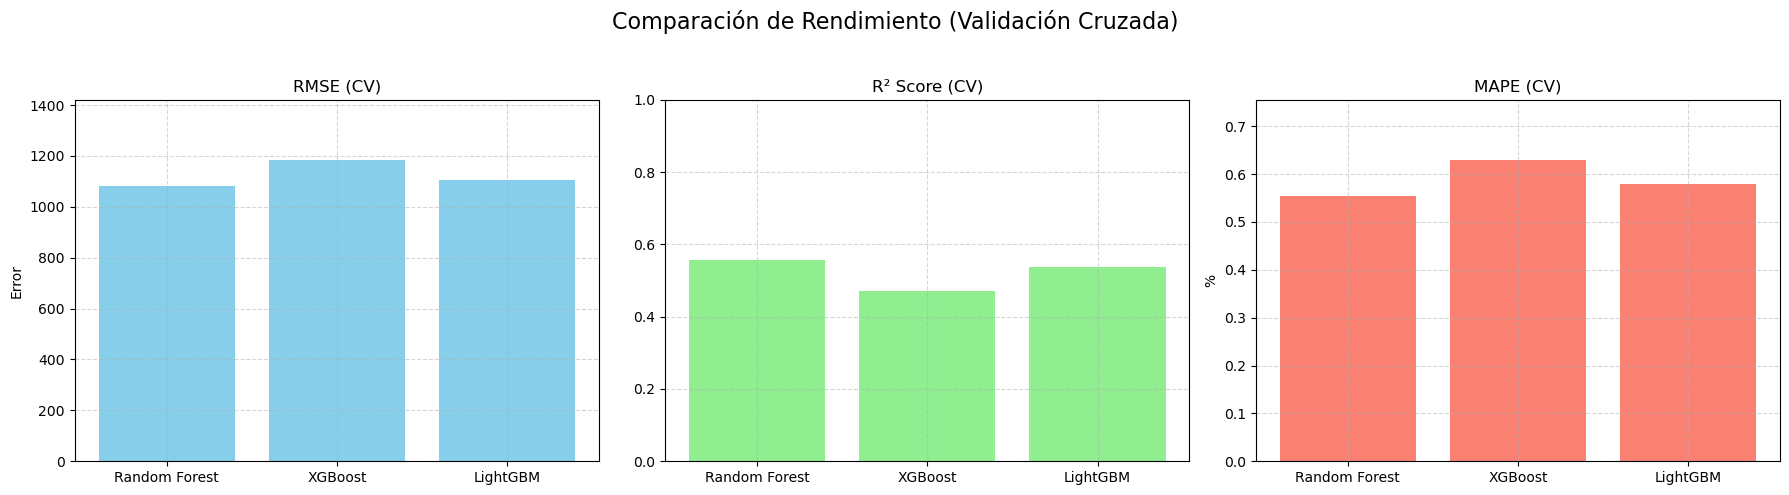

In [69]:
# Datos para el gráfico
model_names = ['Random Forest', 'XGBoost', 'LightGBM']

rmse_scores = [rf_rmse_cv, xgb_rmse_cv, lgbm_rmse_cv]
r2_scores = [rf_r2_cv, xgb_r2_cv, lgbm_r2_cv]
mape_scores = [rf_mape_cv, xgb_mape_cv, lgbm_mape_cv]

# Crear subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# RMSE
axs[0].bar(model_names, rmse_scores, color='skyblue')
axs[0].set_title('RMSE (CV)')
axs[0].set_ylabel('Error')
axs[0].set_ylim(0, max(rmse_scores) * 1.2)
axs[0].grid(True, linestyle='--', alpha=0.5)

# R2
axs[1].bar(model_names, r2_scores, color='lightgreen')
axs[1].set_title('R² Score (CV)')
axs[1].set_ylim(0, 1)
axs[1].grid(True, linestyle='--', alpha=0.5)

# MAPE
axs[2].bar(model_names, mape_scores, color='salmon')
axs[2].set_title('MAPE (CV)')
axs[2].set_ylabel('%')
axs[2].set_ylim(0, max(mape_scores) * 1.2)
axs[2].grid(True, linestyle='--', alpha=0.5)

# Ajustar diseño
plt.suptitle('Comparación de Rendimiento (Validación Cruzada)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [70]:
### Verificar y entrenar Random Forest si no está entrenado
"""try:
   _ = rf_model.feature_importances_
except NotFittedError:
    print("Entrenando Random Forest...")
    rf_model.fit(X_train, y_train)
"""   
###
# Verificar y entrenar XGBoost si no está entrenado
try:
    _ = xgb_model.feature_importances_
except NotFittedError:
    print("Entrenando XGBoost...")
    xgb_model.fit(X_train, y_train)

Entrenando XGBoost...



Importancia de las variables para Random Forest y XGBoost:


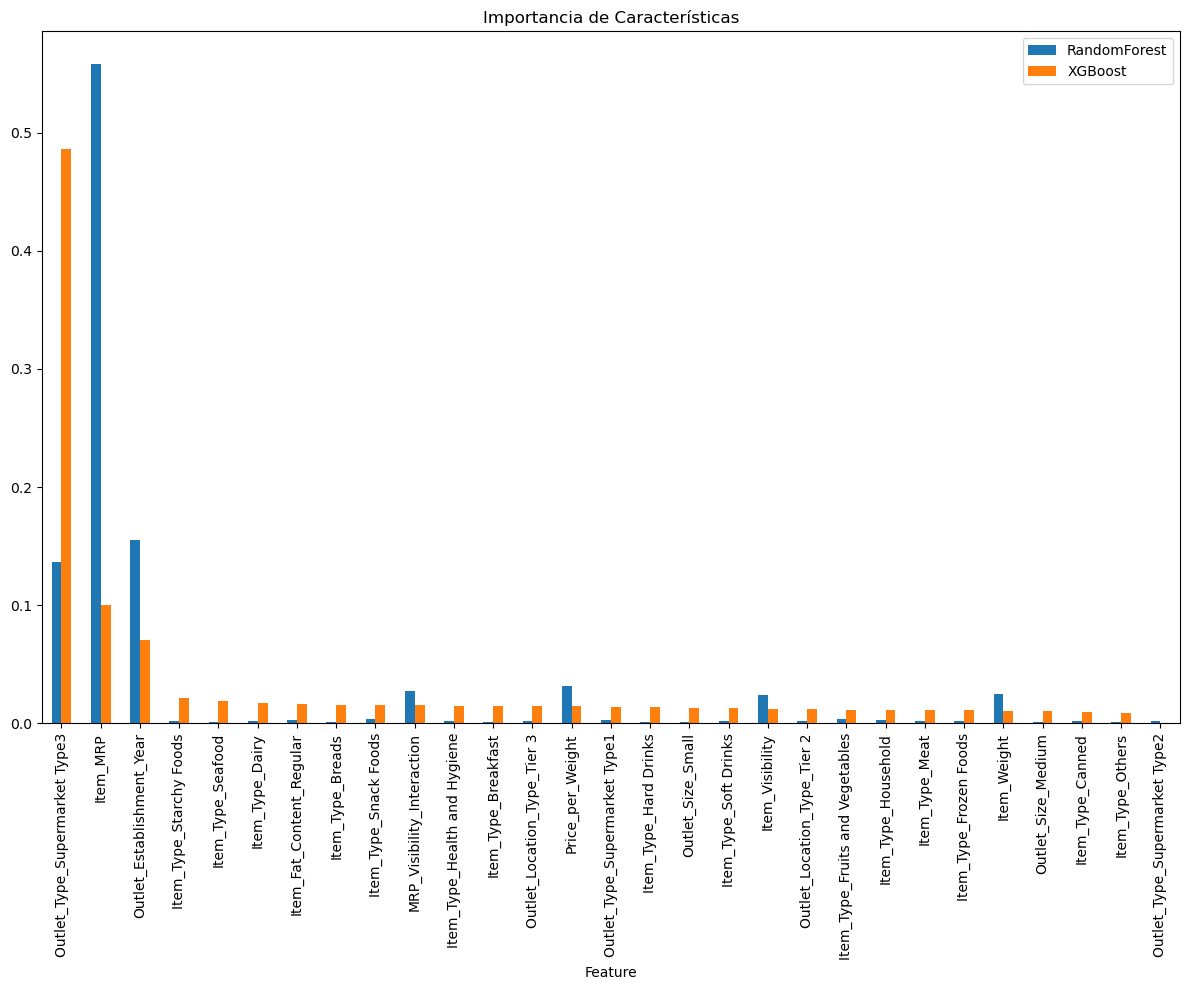

In [71]:
# Opción optimizada
print("\nImportancia de las variables para Random Forest y XGBoost:")
feature_importances = pd.DataFrame({
    'Feature': numerical_features + list(encoder.get_feature_names_out(categorical_features)),
    'RandomForest': rf_model.feature_importances_,
    'XGBoost': xgb_model.feature_importances_
})
feature_importances.set_index('Feature', inplace=True)
feature_importances.sort_values(by='XGBoost', ascending=False, inplace=True)

# Solo esta línea es suficiente para tamaño y graficar
feature_importances.plot(kind='bar', figsize=(12, 10))
plt.title("Importancia de Características")
plt.tight_layout()
plt.show()

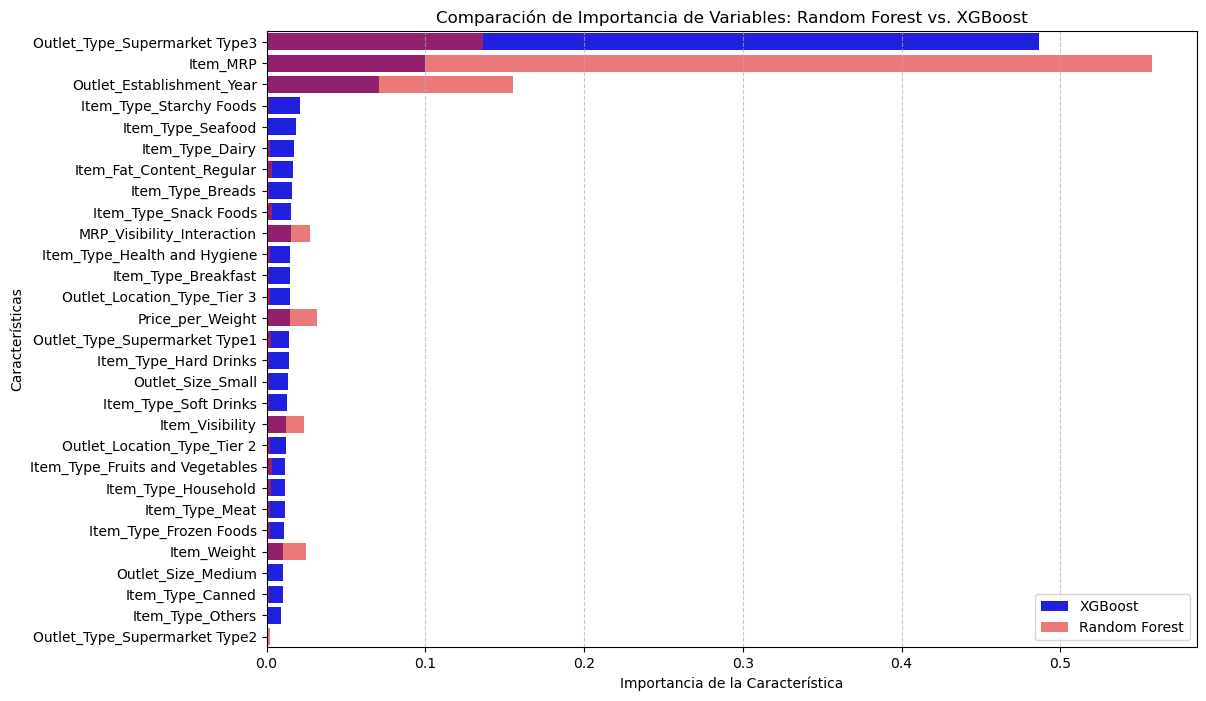

In [72]:
feature_importances = pd.DataFrame({
    'Feature': numerical_features + list(encoder.get_feature_names_out(categorical_features)),
    'RandomForest': rf_model.feature_importances_,
    'XGBoost': xgb_model.feature_importances_
})


feature_importances.sort_values(by='XGBoost', ascending=False, inplace=True)

# Configurar gráfico
plt.figure(figsize=(12, 8))
sns.barplot(
    x=feature_importances['XGBoost'], 
    y=feature_importances['Feature'], 
    color="blue", 
    label="XGBoost"
)
sns.barplot(
    x=feature_importances['RandomForest'], 
    y=feature_importances['Feature'], 
    color="red", 
    alpha=0.6,  
    label="Random Forest"
)

plt.xlabel("Importancia de la Característica")
plt.ylabel("Características")
plt.title("Comparación de Importancia de Variables: Random Forest vs. XGBoost")
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


Importancia de las variables para Random Forest y LightGBM:


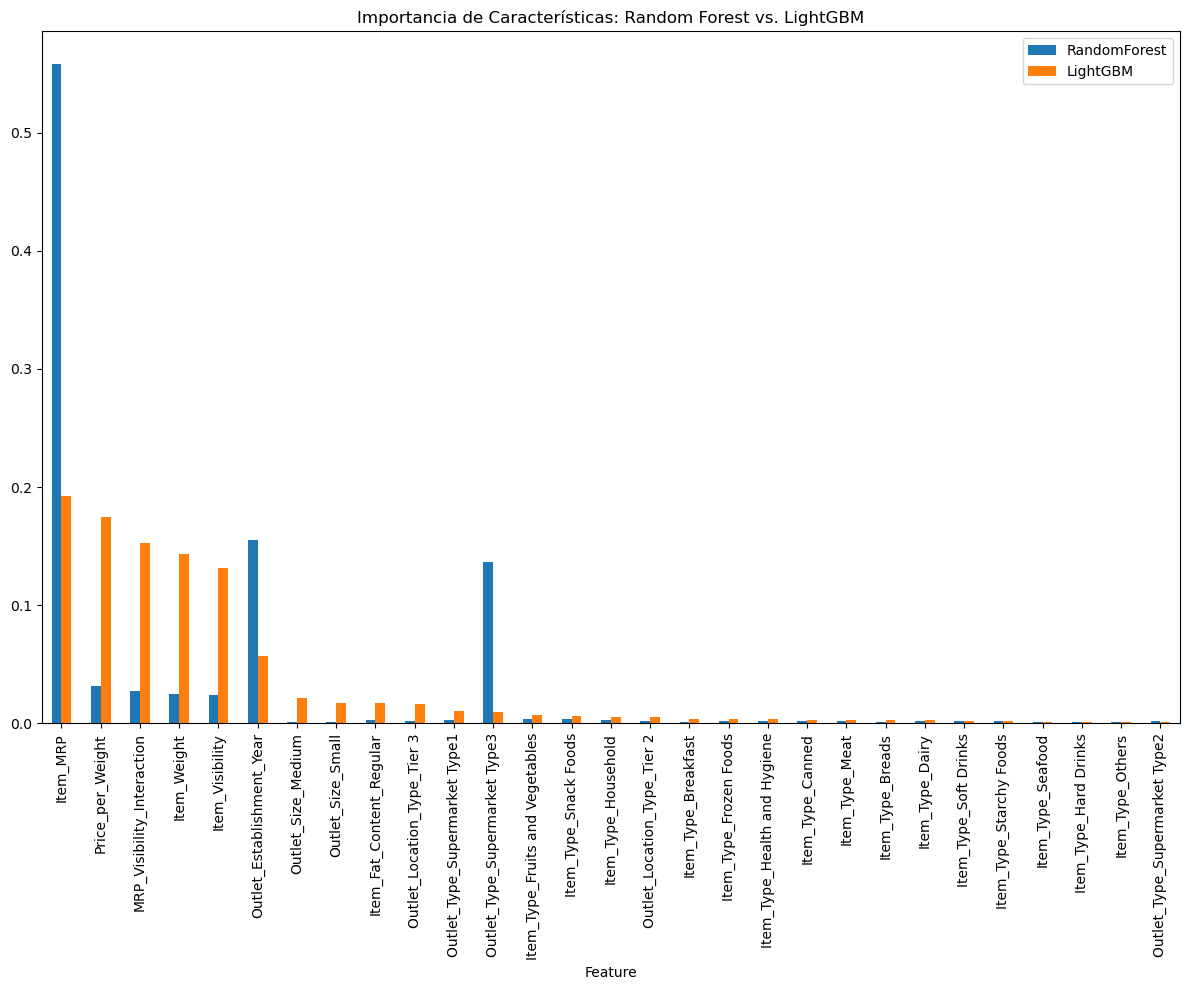

In [73]:
# Opción optimizada
print("\nImportancia de las variables para Random Forest y LightGBM:")
feature_importances = pd.DataFrame({
    'Feature': numerical_features + list(encoder.get_feature_names_out(categorical_features)),
    'RandomForest': rf_model.feature_importances_,
    'LightGBM': lgbm.feature_importances_
})

# Normalizar las importancias de LightGBM para que estén en la misma escala (0 a 1)
feature_importances['LightGBM'] = feature_importances['LightGBM'] / feature_importances['LightGBM'].sum()

# Configurar el índice y ordenar
feature_importances.set_index('Feature', inplace=True)
feature_importances.sort_values(by='LightGBM', ascending=False, inplace=True)

# Graficar
feature_importances.plot(kind='bar', figsize=(12, 10))
plt.title("Importancia de Características: Random Forest vs. LightGBM")
plt.tight_layout()
plt.show()

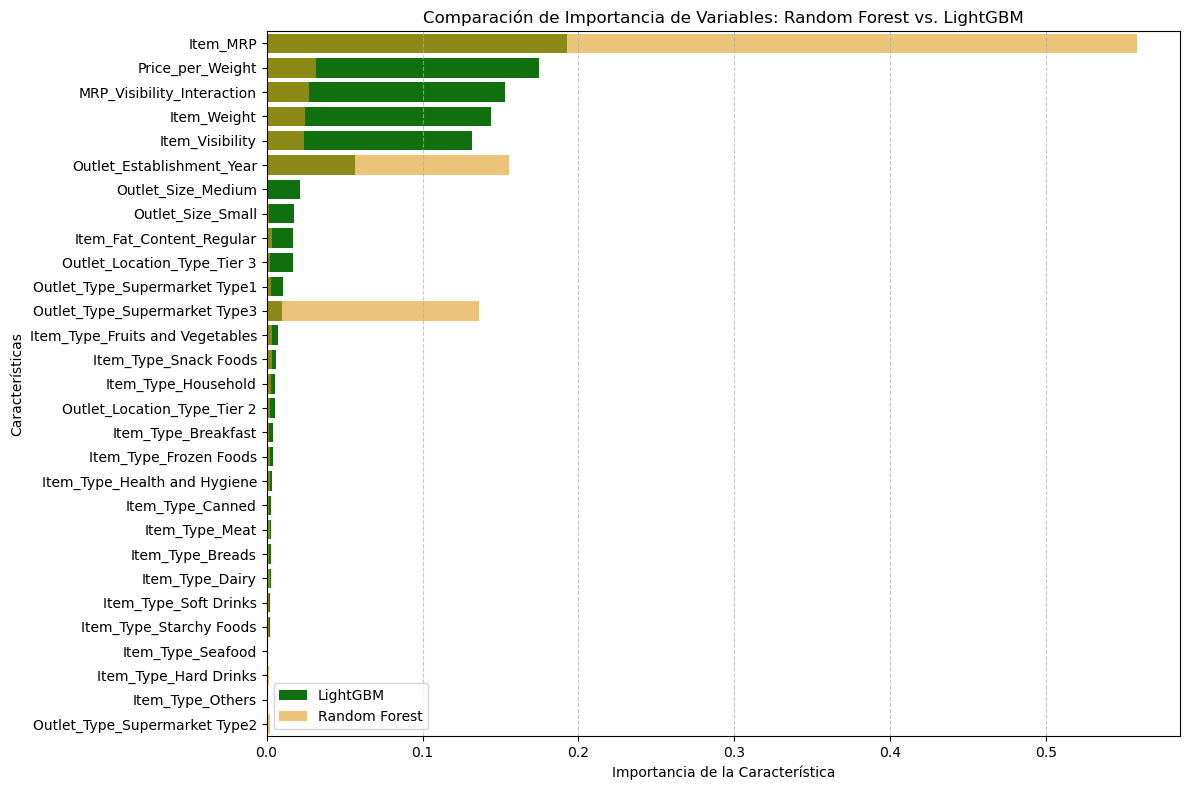

In [74]:
# Crear DataFrame con importancias
feature_importances = pd.DataFrame({
    'Feature': numerical_features + list(encoder.get_feature_names_out(categorical_features)),
    'RandomForest': rf_model.feature_importances_,
    'LightGBM': lgbm.feature_importances_
})

# Normalizar las importancias de LightGBM para que estén en la misma escala (0 a 1)
feature_importances['LightGBM'] = feature_importances['LightGBM'] / feature_importances['LightGBM'].sum()

# Ordenar por LightGBM (de menor a mayor)
feature_importances.sort_values(by='LightGBM', ascending=False, inplace=True)

# Configurar gráfico
plt.figure(figsize=(12, 8))
sns.barplot(
    x=feature_importances['LightGBM'], 
    y=feature_importances['Feature'], 
    color="green", 
    label="LightGBM"
)
sns.barplot(
    x=feature_importances['RandomForest'], 
    y=feature_importances['Feature'], 
    color="orange", 
    alpha=0.6,  
    label="Random Forest"
)

plt.xlabel("Importancia de la Característica")
plt.ylabel("Características")
plt.title("Comparación de Importancia de Variables: Random Forest vs. LightGBM")
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Importancia de las variables para Random Forest, LightGBM y XGBoost:


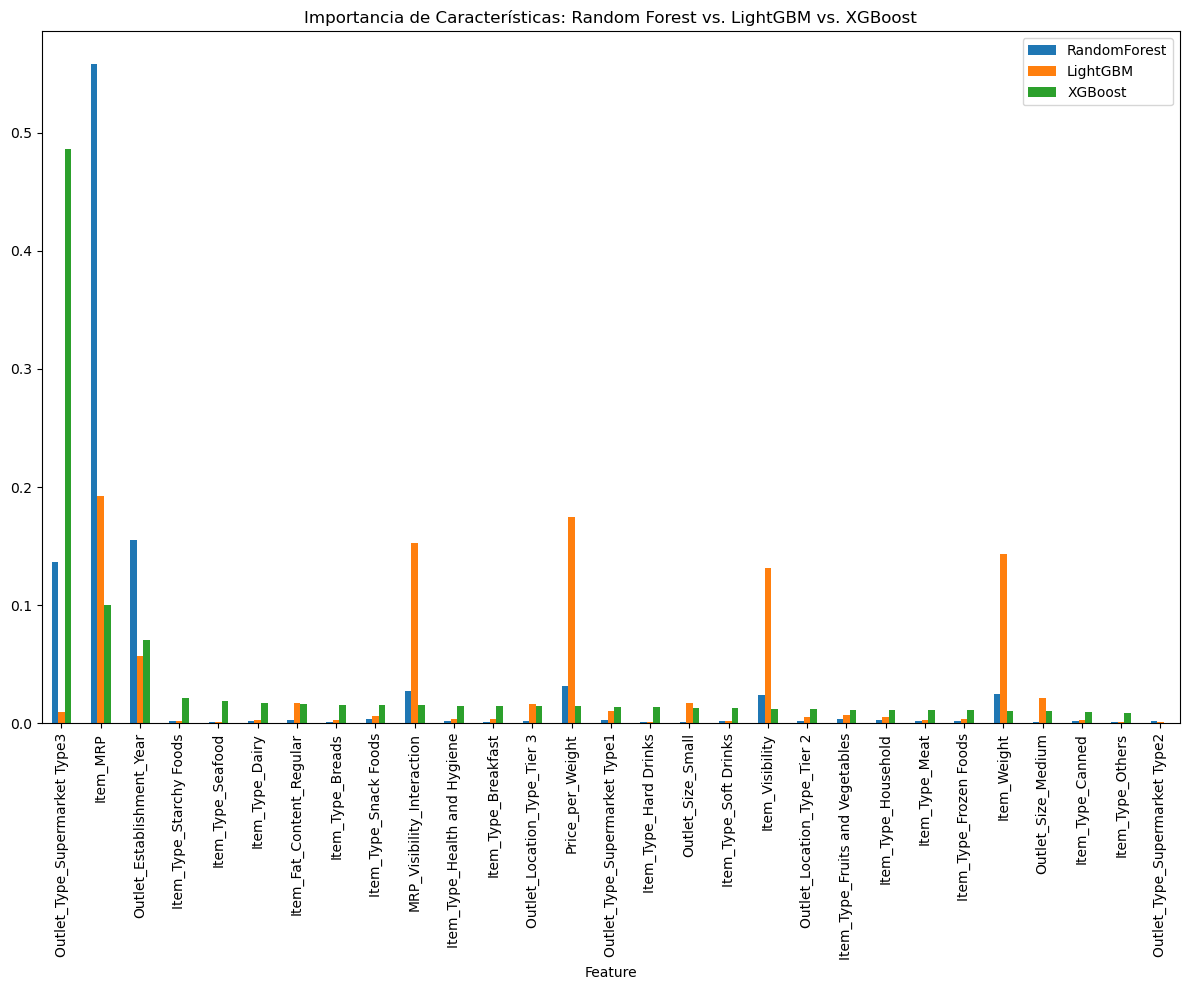

In [75]:
# Opción optimizada
print("\nImportancia de las variables para Random Forest, LightGBM y XGBoost:")
feature_importances = pd.DataFrame({
    'Feature': numerical_features + list(encoder.get_feature_names_out(categorical_features)),
    'RandomForest': rf_model.feature_importances_,
    'LightGBM': lgbm.feature_importances_,
    'XGBoost': xgb_model.feature_importances_
})

# Normalizar las importancias de LightGBM y XGBoost para que estén en la misma escala (0 a 1)
feature_importances['LightGBM'] = feature_importances['LightGBM'] / feature_importances['LightGBM'].sum()
feature_importances['XGBoost'] = feature_importances['XGBoost'] / feature_importances['XGBoost'].sum()

# Configurar el índice y ordenar por XGBoost (puedes cambiar el criterio de ordenamiento si prefieres)
feature_importances.set_index('Feature', inplace=True)
feature_importances.sort_values(by='XGBoost', ascending=False, inplace=True)

# Graficar
feature_importances.plot(kind='bar', figsize=(12, 10))
plt.title("Importancia de Características: Random Forest vs. LightGBM vs. XGBoost")
plt.tight_layout()
plt.savefig('feature_importance.png')

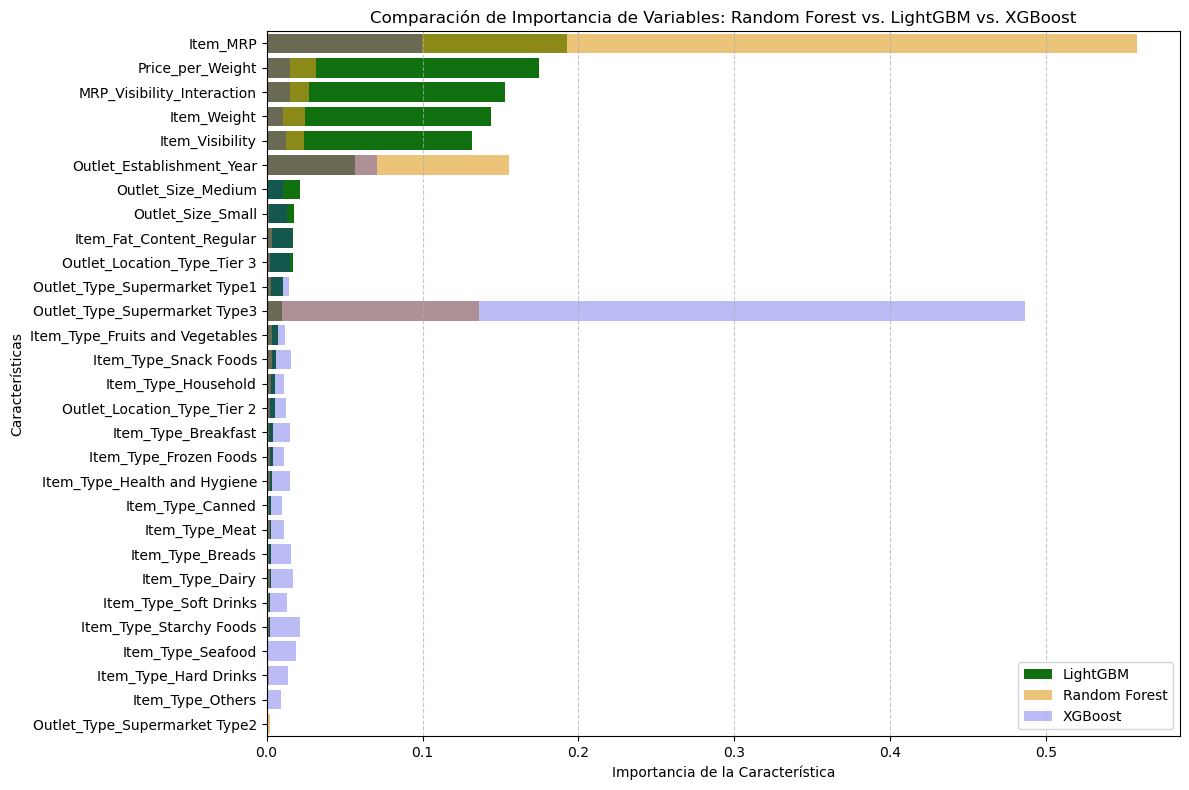

In [76]:
# Crear DataFrame con importancias
feature_importances = pd.DataFrame({
    'Feature': numerical_features + list(encoder.get_feature_names_out(categorical_features)),
    'RandomForest': rf_model.feature_importances_,
    'LightGBM': lgbm.feature_importances_,
    'XGBoost': xgb_model.feature_importances_
})

# Normalizar las importancias de LightGBM y XGBoost para que estén en la misma escala (0 a 1)
feature_importances['LightGBM'] = feature_importances['LightGBM'] / feature_importances['LightGBM'].sum()
feature_importances['XGBoost'] = feature_importances['XGBoost'] / feature_importances['XGBoost'].sum()

# Ordenar por LightGBM (de mayor a menor)
feature_importances.sort_values(by='LightGBM', ascending=False, inplace=True)

# Configurar gráfico
plt.figure(figsize=(12, 8))
sns.barplot(
    x=feature_importances['LightGBM'], 
    y=feature_importances['Feature'], 
    color="green", 
    label="LightGBM"
)
sns.barplot(
    x=feature_importances['RandomForest'], 
    y=feature_importances['Feature'], 
    color="orange", 
    alpha=0.6,  
    label="Random Forest"
)
sns.barplot(
    x=feature_importances['XGBoost'], 
    y=feature_importances['Feature'], 
    color="blue", 
    alpha=0.3,  
    label="XGBoost"
)

plt.xlabel("Importancia de la Característica")
plt.ylabel("Características")
plt.title("Comparación de Importancia de Variables: Random Forest vs. LightGBM vs. XGBoost")
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('feature_importance_barplot.png')

In [77]:
# Define the parameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Configure KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV with KFold
rf_grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    rf_param_grid,
    cv=kfold,
    n_jobs=-1,
    verbose=2
)

# Fit the model
rf_grid_search.fit(X_train, y_train)

# Print the best parameters
print(f"Mejores parámetros de Random Forest: {rf_grid_search.best_params_}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejores parámetros de Random Forest: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 300}


In [78]:
"""# Definicion para LGBM
lgbm_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 62, 127]
}

# Kfold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Grindsearch con Kfold
lgbm_grid_search = GridSearchCV(
    LGBMRegressor(random_state=42),
    lgbm_param_grid,
    cv=kfold,
    n_jobs=-1,
    verbose=2
)

# Fit the model
lgbm_grid_search.fit(X_train, y_train)

# Print the best parameters
print(f"Mejores parámetros de LightGBM: {lgbm_grid_search.best_params_}")"""

'# Definicion para LGBM\nlgbm_param_grid = {\n    \'n_estimators\': [100, 200, 300],\n    \'max_depth\': [5, 10, 15],\n    \'learning_rate\': [0.01, 0.05, 0.1],\n    \'num_leaves\': [31, 62, 127]\n}\n\n# Kfold\nkfold = KFold(n_splits=5, shuffle=True, random_state=42)\n\n# Grindsearch con Kfold\nlgbm_grid_search = GridSearchCV(\n    LGBMRegressor(random_state=42),\n    lgbm_param_grid,\n    cv=kfold,\n    n_jobs=-1,\n    verbose=2\n)\n\n# Fit the model\nlgbm_grid_search.fit(X_train, y_train)\n\n# Print the best parameters\nprint(f"Mejores parámetros de LightGBM: {lgbm_grid_search.best_params_}")'

##### Nota: No se hace el LightGBM por motivos de que da error, pese a ser el mejor algoritmo.

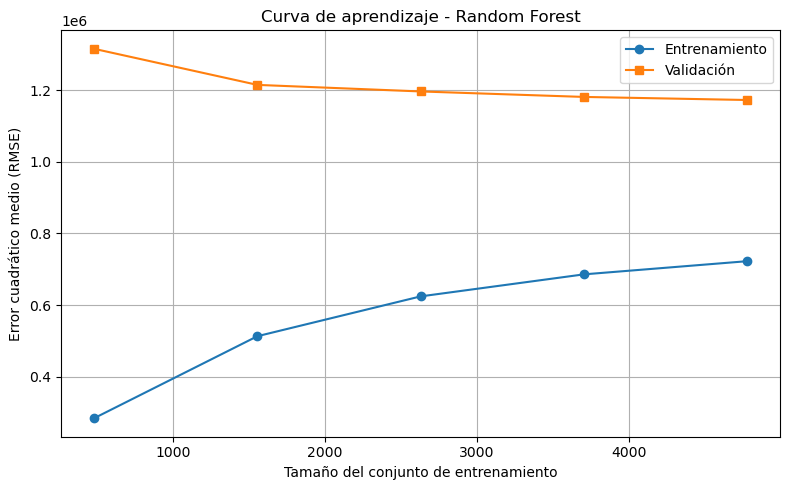

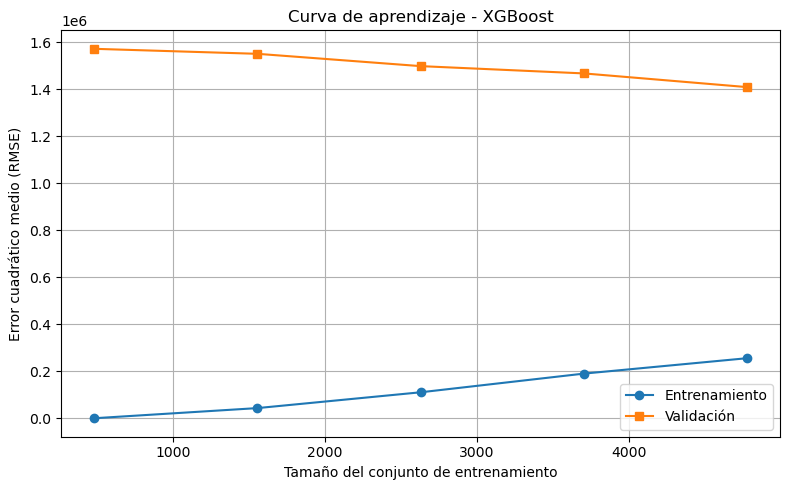

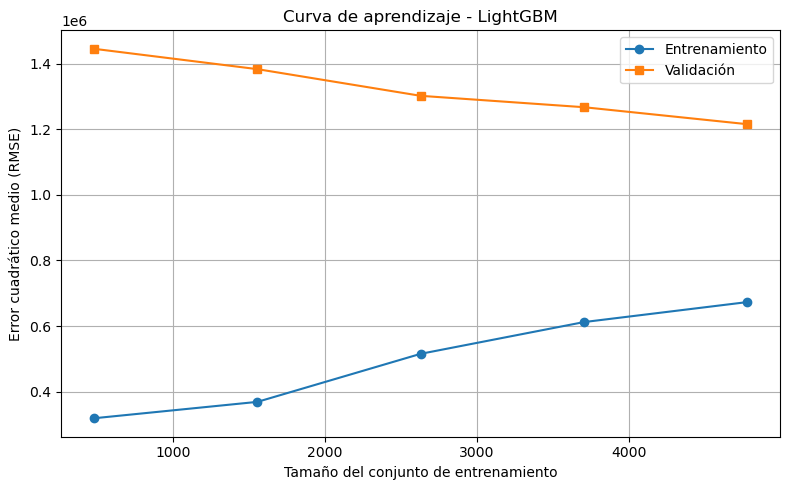

In [79]:
def plot_learning_curve(model, X, y, model_name="Modelo"):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    train_scores_mean = -train_scores.mean(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_scores_mean, label="Entrenamiento", marker='o')
    plt.plot(train_sizes, test_scores_mean, label="Validación", marker='s')
    plt.xlabel('Tamaño del conjunto de entrenamiento')
    plt.ylabel('Error cuadrático medio (RMSE)')
    plt.title(f'Curva de aprendizaje - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Llamadas con nombre personalizado
plot_learning_curve(rf_model, X_train, y_train, model_name="Random Forest")
plot_learning_curve(xgb_model, X_train, y_train, model_name="XGBoost")
plot_learning_curve(lgbm_model, X_train, y_train, model_name="LightGBM")

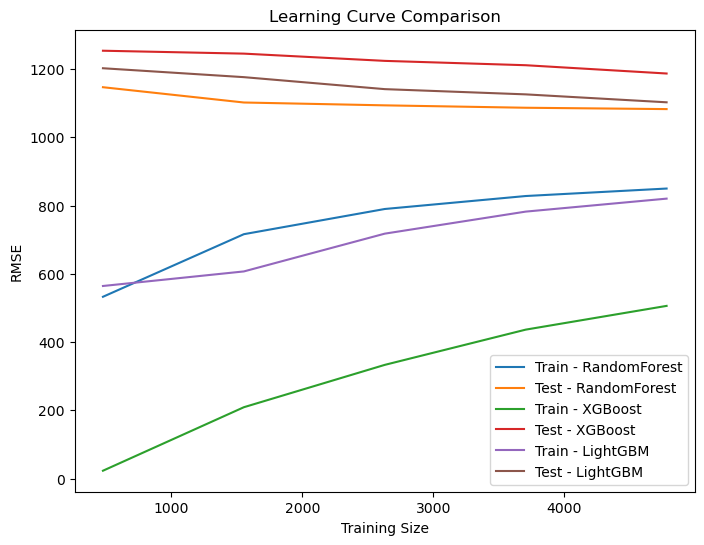

In [80]:
def plot_learning_curve(model, X, y, model_name):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    
    train_scores_mean = np.sqrt(-train_scores.mean(axis=1))  # Convertir MSE a RMSE
    test_scores_mean = np.sqrt(-test_scores.mean(axis=1))
    
    plt.plot(train_sizes, train_scores_mean, label=f"Train - {model_name}")
    plt.plot(train_sizes, test_scores_mean, label=f"Test - {model_name}")
    
# Graficar curvas de aprendizaje
plt.figure(figsize=(8, 6))
plot_learning_curve(rf_model, X_train, y_train, "RandomForest")
plot_learning_curve(xgb_model, X_train, y_train, "XGBoost")
plot_learning_curve(lgbm_model, X_train, y_train, "LightGBM")

plt.xlabel('Training Size')
plt.ylabel('RMSE')
plt.title('Learning Curve Comparison')
plt.legend()
plt.show()

#### Guardado de prediccion

In [81]:
test_predictions = rf_model.predict(X_test)

# Guardar resultados
submission = pd.DataFrame({
    'Item_Identifier': test['Item_Identifier'],
    'Outlet_Identifier': test['Outlet_Identifier'],
    'Item_Outlet_Sales': test_predictions
})
submission.to_csv('submission_final.csv', index=False)

In [82]:
# Predicción en dataset de test
test_predictions = rf_model.predict(X_test)
test['Predicted_Sales'] = test_predictions

# Guardar resultados
test[['Item_Identifier', 'Outlet_Identifier', 'Predicted_Sales']].to_csv('submission.csv', index=False)
print("Predicciones guardadas en 'submission2.csv'")

Predicciones guardadas en 'submission2.csv'


In [83]:
# Guardar solo el modelo RandomForest
dump(rf_model, "random_forest_model.joblib")

print("Modelo RandomForest guardado correctamente.")

Modelo RandomForest guardado correctamente.


### Conclusion

#### Análisis del Desarrollo del Modelo de Predicción

Durante el desarrollo del modelo de predicción, se identificaron diversos problemas que impactaban directamente en la calidad y precisión de los resultados. Estas observaciones surgieron a partir de diferentes análisis exploratorios realizados sobre el conjunto de datos.

#### Problemas Detectados en la Calidad de los Datos

Uno de los primeros hallazgos fue la presencia significativa de **valores faltantes**. Se observó que eliminar directamente las filas con datos incompletos provocaría la pérdida del **45% del dataset**, lo cual comprometería seriamente la representatividad del modelo.

##### Análisis Estadístico Exploratorio

Se plantearon diferentes hipótesis utilizando técnicas estadísticas. Un foco importante del análisis fue entender el comportamiento de las **tiendas**, analizando variables como:

- **Tamaño de la tienda**
- **Tipo de tienda**
- **Tipo de ítem vendido**

Esto permitió observar correlaciones relevantes que ayudaron a enriquecer la construcción de los modelos.

##### Desarrollo y Evaluación de Modelos Predictivos

Para abordar los factores que afectaban la calidad de las predicciones, se construyeron varios modelos usando diferentes algoritmos de machine learning. Los algoritmos implementados fueron:

- **XGBoost**
- **Random Forest**
- **LightGBM**
- **Red Neuronal**
- **Regresión Lineal**
- **Gradient Boosting**
- **Support Vector Machine (SVM)**

Cada modelo fue evaluado rigurosamente para detectar posibles problemas de **overfitting** o **underfitting**, y se analizaron diversas métricas de rendimiento (como precisión, error cuadrático medio, etc.).

##### Resultados del Análisis de Modelos

- No se encontró evidencia significativa de overfitting ni underfitting en los modelos evaluados, lo que indica que el ajuste fue adecuado.
- Entre todos los modelos, los tres con mejor desempeño fueron:
  - **Random Forest**
  - **XGBoost**
  - **LightGBM**

Tras comparar el rendimiento de estos tres algoritmos en las fases de entrenamiento y prueba, se concluyó que **Random Forest** fue el que ofreció los resultados más sólidos y consistentes.

#### Fuentes de Datos Externos para Mejorar el Modelo

Se identificaron posibles fuentes externas de datos que podrían potenciar la capacidad predictiva del modelo:

- **Tráfico web de la tienda (si aplica):**  
  Información sobre visitas al sitio web o tráfico en línea podría servir como un indicador directo de la demanda, permitiendo ajustar las predicciones de manera más dinámica y precisa.

- **Comentarios y valoraciones de los productos:**  
  Los datos relacionados con la satisfacción del cliente, provenientes de reseñas y valoraciones, pueden revelar cuáles productos son más populares, cuál es la percepción general del mercado y qué ítems generan mayor rentabilidad.

---

